# Телеком 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
<br><br>
Основная метрика качества модели: **ROC-AUC** (>= 0.85)<br>
Дополнительная метрика: **accuracy**


### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарная телефонная связь. Возможность подключения телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).
<br><br>
Также доступны такие интернет-услуги:
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).
<br><br>

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года.<br> 
Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- [`contract_new.csv`](https://code.s3.yandex.net/datasets/contract_new.csv) — информация о договоре;
- [`personal_new.csv`](https://code.s3.yandex.net/datasets/personal_new.csv) — персональные данные клиента;
- [`internet_new.csv`](https://code.s3.yandex.net/datasets/internet_new.csv) — информация об интернет-услугах;
- [`phone_new.csv`](https://code.s3.yandex.net/datasets/phone_new.csv) — информация об услугах телефонии.
<br><br>

Во всех файлах столбец `customerID` содержит код клиента.<br>
Информация о договорах актуальна на 1 февраля 2020.
<br><br>
Признаки:

- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами, 
- `Type` – тип оплаты: ежемесячный, годовой и тд, 
- `PaperlessBilling` – безналичный расчет, 
- `PaymentMethod` – способ оплаты, 
- `MonthlyCharges` – ежемесячные траты на услуги, 
- `TotalCharges` – всего потрачено денег на услуги 
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и),
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

# План работы

- **предобработка данных** (заполнение пропусков, проверка типов данных, дедупликация, поиск ошибок, категоризация данных, формат названия столбцов);
- **предварительный анализ данных** (функция, выводящая основные параметры датасетов для каждого из них);
- **консультация с тимлидом** (уточнение задачи и сроков, вопросы о данных, переменных, модели, есть ли дополнительные факторы, которые нужно учесть, уточнение формата отчета)
- **исследовательский анализ данных** (графики: гистограммы, "ящики с усами", анализ распределений, удаление аномалий/выбросов, анализ важности и взаимосвязи признаков, генерирование признаков, срезы данных)
- **подготовка данных для модели** (разделение целевого признака и остальных признаков, удаление лишних признаков, разбивка данных на обучающую, валидационную и тестовую выборки, перекодирование категориальных признаков, масштабирование данных)
- **обучение и валидация модели** (выбор и обучение модели, подбор гиперпараметров, достижение требуемого значения ROC-AUC, проверка лучшей модели на тестовой выборке)
- **подготовка отчета**

Вопросы к тимлиду:
- Что заказчик ожидает увидеть в отчете? В каком формате нужен отчет? Кому будут презентоваться результаты?
- Нет ли ограничений по моделям (время обучения/предсказания, интерпретируемость)?
- Какие признаки нельзя использовать?
- Где будет проверяться прототип модели (делать ли тестовую выборку)?



# Основная часть

## Предварительный анализ и предобработка данных

In [1]:
# импорт библиотек

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # разбивка выборки на обучающую и валидационную

# модели
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier # дерево-классификатор
from sklearn.ensemble import RandomForestClassifier # лес-классификатор
!pip install catboost
from catboost import CatBoostClassifier # CatBoost-классификатор 
# !pip install lightgbm
# from lightgbm import LGBMClassifier # LGBM-классификатор
from sklearn.model_selection import RandomizedSearchCV # подбор оптимальных гиперпараметров
from sklearn.model_selection import cross_val_score # оценка качества модели кросс-валидацией

# метрики
from sklearn.metrics import roc_auc_score # ROC-AUC
# на вход принимает не предсказания, а прогноз вероятности класса «1».
# roc_auc_score(target_valid, probabilities_one_valid)

# probabilities_valid = model.predict_proba(features_valid) - прогноз вероятностей
# probabilities_one_valid = probabilities_valid[:, 1] - прогноз вероятности класса «1»
from sklearn.metrics import roc_curve # ROC-кривая
from sklearn.metrics import accuracy_score # accuracy
from sklearn.metrics import precision_score # точность
from sklearn.metrics import recall_score # полнота
from sklearn.metrics import confusion_matrix # матрица ошибок

# признаки
from sklearn.feature_selection import SelectKBest # отбор лучших признаков
from sklearn.feature_selection import VarianceThreshold # удаление признаков с минимальной вариацией
from sklearn.feature_selection import mutual_info_classif # важность признаков для классификации 
from sklearn.impute import KNNImputer # заполнение пропусков методом к ближайших соседей
from sklearn.preprocessing import OneHotEncoder # OHE (учить только на train)
from sklearn.preprocessing import StandardScaler # шкалирование (учить только на train)
!pip install category-encoders # установили category-encoders
from category_encoders.cat_boost import CatBoostEncoder # установили CatBoostEncoder

from sklearn.compose import make_column_transformer
# установим phik
!pip install phik
# библиотека phik
import phik
from phik.report import plot_correlation_matrix
from phik import report


In [2]:
# зафиксируем константу
RANDOM_STATE=80523

In [3]:
# Импорт данных

try:
    contract = pd.read_csv('/Users/user/My Python Stuff/contract_new.csv', parse_dates=['BeginDate'], index_col=['customerID'])
    personal = pd.read_csv('/Users/user/My Python Stuff/personal_new.csv', index_col=['customerID'])
    internet = pd.read_csv('/Users/user/My Python Stuff/internet_new.csv', index_col=['customerID'])
    phone = pd.read_csv('/Users/user/My Python Stuff/phone_new.csv', index_col=['customerID'])
    
except:
    contract = pd.read_csv('/datasets/contract_new.csv', parse_dates=['BeginDate'], index_col=['customerID'])
    personal = pd.read_csv('/datasets/personal_new.csv', index_col=['customerID'])
    internet = pd.read_csv('/datasets/internet_new.csv', index_col=['customerID'])
    phone = pd.read_csv('/datasets/phone_new.csv', index_col=['customerID'])

In [4]:
# info(), head(), describe(), value_counts()
# функция для описания df
def get_data_info(data):
    print('Описание датафрейма:')
    display(data.info())
    print()
    print('Случайные 10 строк датафрейма:')
    display(data.sample(10))
    print()
    print('Описательная статистика по переменным:')
    display(data.describe(include='all'))
    print()
    print('Кол-во уникальных строк в датафрейме:')
    display(data.value_counts())
    print()
    print('Кол-во пропусков по переменным:')
    display(data.isna().sum())

In [5]:
# посмотрим на contract
get_data_info(contract)

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


None


Случайные 10 строк датафрейма:


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
9629-NHXFW,2020-01-01,No,Month-to-month,Yes,Mailed check,19.40,19.4
5998-VVEJY,2017-08-01,No,Month-to-month,Yes,Electronic check,80.50,2632.35
0401-WDBXM,2014-02-01,No,Two year,Yes,Bank transfer (automatic),105.55,7599.6
2589-AYCRP,2015-12-01,No,One year,No,Bank transfer (automatic),19.75,1076.38
6048-NJXHX,2016-09-01,No,Two year,Yes,Electronic check,19.75,825.95
9531-NSBMR,2017-02-01,No,One year,Yes,Bank transfer (automatic),19.25,693.0
4332-MUOEZ,2018-06-01,No,One year,No,Credit card (automatic),94.30,1886.0
8883-GRDWQ,2018-06-01,No,One year,No,Mailed check,54.00,1080.0
7921-BEPCI,2014-02-01,2017-01-01,Two year,No,Bank transfer (automatic),59.75,2091.25



Описательная статистика по переменным:


<ipython-input-4-c4e17d19bc70>:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043.000000,7043
unique,77,67,3,2,4,NaN,6658
top,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,
freq,366,5942,3875,4171,2365,NaN,11
first,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,NaN



Кол-во уникальных строк в датафрейме:


BeginDate   EndDate  Type            PaperlessBilling  PaymentMethod              MonthlyCharges  TotalCharges
2020-01-01  No       Month-to-month  No                Mailed check               19.55           19.55           3
2014-02-01  No       Two year        No                Bank transfer (automatic)  92.00           6624.0          2
2019-12-01  No       Month-to-month  Yes               Electronic check           69.60           139.2           2
2020-01-01  No       Month-to-month  Yes               Mailed check               70.60           70.6            2
                                     No                Mailed check               20.35           20.35           2
                                                                                                                 ..
2018-11-01  No       Month-to-month  No                Electronic check           101.75          1587.3          1
                                                       Mailed check          


Кол-во пропусков по переменным:


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Выводы и действия по датафрейму **contract**:
- пропусков нет
- `customerID` уникальный, можно было его положить в индекс при чтении CSV
- из 7043 строк уникальных 7006, когда `customerID` в индекс, вероятно есть 37 пользователей который 2020-02-01 только стали пользователями и по ним еще нет никаких данных, однако `customerID` у них разный 
- большая часть клиентов остались top-значение по `EndDate` 'No' (вероятно, будет дисбаланс классов) 
- `BeginDate` нужно привести к формату даты
- `EndDate` т.к. данные на 1 февраля 2020, 'No' перекодировать в '2020-02-01' и к формату даты
- из `EndDate` сделать таргет: Если EndDate != 'No', то target == 1 (т.е. клиент ушел, прогнозируем уходы)
- сгенерировать признак длительность контракта  `EndDate` - `BeginDate`
- сравнение средних уходов в зависимости от типа оплаты `Type` (почему-то 3 уникальных значения) 
- сравнение средних уходов в зависимости от нал/безнал  `PaperlessBilling`
- `TotalCharges` к типу float64
- можно кластерный анализ сделать - портреты клиентов
- перекодирование категориальных признаков после разделения train и test

In [6]:
# получим таргет из EndDate

# функция-перекодировщик, которую применим к столбцу EndDate: 

def get_target (EndDate):
    try:
        if EndDate != 'No':
            return 1
        else:
            return 0
    except:
        pass

In [7]:
contract['churn'] = contract['EndDate'].apply(get_target)

In [8]:
# посмотрим как отработала функция
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   churn             7043 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 495.2+ KB


None

In [9]:
display(contract.sample(10))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,
8292-TYSPY,2018-05-01,No,Month-to-month,Yes,Credit card (automatic),55.00,1155.0,0
4471-KXAUH,2016-04-01,No,Month-to-month,Yes,Electronic check,84.30,3877.8,0
2921-XWDJH,2016-12-01,No,Month-to-month,Yes,Electronic check,83.45,3171.1,0
6599-RCLCJ,2016-01-01,2017-11-01,Month-to-month,Yes,Electronic check,109.55,2410.1,1
1335-NTIUC,2019-05-01,No,Month-to-month,Yes,Electronic check,24.95,244.76,0
8242-JSVBO,2019-07-01,No,Month-to-month,Yes,Bank transfer (automatic),44.65,312.55,0
8128-YVJRG,2019-05-01,No,Month-to-month,Yes,Mailed check,79.65,716.85,0
7460-ITWWP,2016-05-01,No,Month-to-month,Yes,Electronic check,86.10,4223.2,0
3365-SAIGS,2018-09-01,No,Month-to-month,Yes,Electronic check,83.55,1477.16,0


In [10]:
# EndDate == 'No' перекодировать в '2020-02-01'

contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [11]:
# EndDate к формату даты 
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

In [12]:
# BeginDate к формату даты pd, а не np
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

In [13]:
# посмотрим как отработал

display(contract.sample(10))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
customerID,,,,,,,,
0014-BMAQU,2014-11-01,2020-02-01,Two year,Yes,Credit card (automatic),84.65,5332.95,0
9426-SXNHE,2019-12-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),18.75,40.12,0
5027-QPKTE,2019-06-01,2020-02-01,Month-to-month,Yes,Electronic check,69.35,554.8,0
4853-OITSN,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,89.15,445.75,0
6726-NNFWD,2014-03-01,2018-10-01,Two year,No,Credit card (automatic),89.45,4919.75,1
2137-DQMEV,2014-06-01,2020-02-01,One year,No,Mailed check,44.80,3076.86,0
0929-PECLO,2014-11-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),89.60,5644.8,0
9337-SRRNI,2014-08-01,2019-05-01,Two year,Yes,Credit card (automatic),25.30,1442.1,1
2055-PDADH,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.40,362.56,0


In [14]:
# сгенерируем переменную: сколько дней клиент с оператором

contract['how_long'] = round((contract['EndDate']-contract['BeginDate']) / np.timedelta64 ( 1 , 'D')).astype(int)

In [15]:
display(contract.sample(10))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long
customerID,,,,,,,,,
3836-FZSDJ,2014-03-01,2018-03-01,Two year,No,Bank transfer (automatic),24.85,1300.15,1,1461
2955-PSXOE,2019-09-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),20.20,102.01,0,153
6537-QLGEX,2018-10-01,2020-02-01,Month-to-month,Yes,Electronic check,38.90,622.4,0,488
5133-POWUA,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,45.80,47.63,0,31
5913-INRQV,2017-04-01,2020-02-01,One year,No,Mailed check,90.15,3187.7,0,1036
9572-WUKSB,2019-11-01,2020-02-01,Month-to-month,Yes,Electronic check,29.90,89.7,0,92
7654-YWJUF,2016-07-01,2019-05-01,One year,Yes,Bank transfer (automatic),84.25,2864.5,1,1034
3890-RTCMS,2018-10-01,2020-02-01,Month-to-month,Yes,Mailed check,49.45,791.2,0,488
1228-FZFRV,2015-08-01,2020-02-01,Month-to-month,No,Credit card (automatic),105.95,5721.3,0,1645


In [16]:
sample1 = contract[(contract['BeginDate'] == '2020-02-01')]

In [17]:
display(sample1)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long
customerID,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0,0


In [18]:
print("количество пользователей присоединившихся 2020-02-01:", sample1.shape[0])

количество пользователей присоединившихся 2020-02-01: 11


Примечательно, что все вновь присоединившиеся пользователи берут годовой, а не ежемесячный способ оплаты.<br><br>
У вновь присоединившихся клиентов в `TotalCharges` " ", т.к. у них еще нет общих расходов, только расходы за месяц, в который они присоединились. На них и необходимо необходимо заменить ' '.

In [19]:
# заменим " " в TotalCharges на значения MonthlyCharges  
contract.loc[contract['TotalCharges'] == ' ', 'TotalCharges'] = contract['MonthlyCharges']

In [20]:
# посмотрим на результат
display(contract[(contract['BeginDate'] == '2020-01-01')])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31
3413-BMNZE,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),45.25,45.25,0,31
2273-QCKXA,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,49.05,52.48,0,31
2424-WVHPL,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,74.70,79.93,0,31
...,...,...,...,...,...,...,...,...,...
1724-IQWNM,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.30,20.07,0,31
6127-IYJOZ,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,45.85,45.85,0,31
9108-EJFJP,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,53.55,55.69,0,31


In [21]:
# TotalCharges к типу float64
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

In [22]:
display(contract.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   how_long          7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 870.2+ KB


None

In [23]:
# список псевдо-дублей, т.е. пользователей у которых совпадает все, кроме ID, т.е. это разные пользователи
display(contract[contract.duplicated()])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long
customerID,,,,,,,,,
7617-EYGLW,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31
0031-PVLZI,2019-09-01,2020-02-01,Month-to-month,No,Mailed check,20.35,101.75,0,153
8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,0,31
1133-KXCGE,2018-08-01,2020-02-01,One year,No,Mailed check,20.10,361.80,0,549
2668-TZSPS,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.45,20.45,0,31
9617-INGJY,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,70.60,70.60,0,31
4112-LUEIZ,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,89.50,984.50,0,337
8566-YPRGL,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,19.50,19.50,0,31
9430-NKQLY,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),25.10,1807.20,0,2191


In [24]:
# проверка и пример: все совпадает, кроме ID
display(contract.query('BeginDate == "2020-01-01" and EndDate == "2020-02-01" and Type == "Month-to-month" and PaperlessBilling == "No" and PaymentMethod == "Electronic check" and MonthlyCharges == 19.45'))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long
customerID,,,,,,,,,
3679-XASPY,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31
7617-EYGLW,2020-01-01,2020-02-01,Month-to-month,No,Electronic check,19.45,19.45,0,31


In [25]:
print(contract.describe())

       MonthlyCharges  TotalCharges        churn     how_long
count     7043.000000   7043.000000  7043.000000  7043.000000
mean        64.761692   2115.377573     0.156325   898.555729
std         30.090047   2112.678861     0.363189   683.130510
min         18.250000     19.050000     0.000000     0.000000
25%         35.500000    436.750000     0.000000   276.000000
50%         70.350000   1343.350000     0.000000   761.000000
75%         89.850000   3236.690000     0.000000  1461.000000
max        118.750000   9221.380000     1.000000  2314.000000


In [26]:
# посмотрим на personal
get_data_info(personal)

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None


Случайные 10 строк датафрейма:


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
8802-UNOJF,Male,1,No,No
4808-YNLEU,Female,0,Yes,No
8818-DOPVL,Female,1,No,No
7989-AWGEH,Male,0,Yes,Yes
3284-SVCRO,Female,0,Yes,No
5198-HQAEN,Male,0,Yes,Yes
7206-PQBBZ,Male,1,Yes,No
5018-HEKFO,Female,0,No,No
7733-UDMTP,Female,1,No,No



Описательная статистика по переменным:


,gender,SeniorCitizen,Partner,Dependents
count,7043,7043.000000,7043,7043
unique,2,NaN,2,2
top,Male,NaN,No,No
freq,3555,NaN,3641,4933
mean,NaN,0.162147,NaN,NaN
std,NaN,0.368612,NaN,NaN
min,NaN,0.000000,NaN,NaN
25%,NaN,0.000000,NaN,NaN
50%,NaN,0.000000,NaN,NaN
75%,NaN,0.000000,NaN,NaN



Кол-во уникальных строк в датафрейме:


gender  SeniorCitizen  Partner  Dependents
Male    0              No       No            1381
Female  0              No       No            1338
                       Yes      Yes            844
Male    0              Yes      Yes            822
Female  0              Yes      No             596
Male    0              Yes      No             567
Female  1              No       No             317
Male    1              Yes      No             281
                       No       No             244
        0              No       Yes            211
Female  1              Yes      No             209
        0              No       Yes            142
Male    1              Yes      Yes             44
Female  1              Yes      Yes             39
Male    1              No       Yes              5
Female  1              No       Yes              3
dtype: int64


Кол-во пропусков по переменным:


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Выводы и действия по датафрейму **personal**:
- пропусков нет
- строки уникальные
- мужчин в датафрейме больше чем женщин, одиноких и бездетных больше, чем с партнером и детьми. Посмотреть на срезы. 
- `gender`, `Partner`, `Dependents`, `Senior Citizen` перекодировать в dummy (после разделения на train и test) 

In [27]:
# уникальные значений в 'SeniorCitizen'
print(personal['SeniorCitizen'].unique())

[0 1]


In [28]:
# посмотрим на personal
get_data_info(internet)

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


None


Случайные 10 строк датафрейма:


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
5736-YEJAX,DSL,Yes,Yes,Yes,Yes,Yes,No
0415-MOSGF,DSL,No,No,No,No,No,No
0327-WFZSY,Fiber optic,No,No,Yes,No,Yes,Yes
2522-AHJXR,Fiber optic,Yes,No,Yes,Yes,Yes,Yes
2403-BCASL,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
0004-TLHLJ,Fiber optic,No,No,Yes,No,No,No
0219-YTZUE,Fiber optic,No,Yes,Yes,No,No,No
2162-FRZAA,DSL,No,Yes,Yes,Yes,No,No
4369-NYSCF,DSL,No,Yes,No,Yes,Yes,Yes



Описательная статистика по переменным:


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785



Кол-во уникальных строк в датафрейме:


InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies
Fiber optic      No              No            No                No           No           No                 399
DSL              No              No            No                No           No           No                 294
Fiber optic      No              No            No                No           Yes          Yes                181
                                 Yes           Yes               No           Yes          Yes                164
                                 No            Yes               No           Yes          Yes                149
                                                                                                             ... 
                 Yes             No            No                Yes          No           No                   9
                                               Yes               No           No           Yes 


Кол-во пропусков по переменным:


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Выводы и действия по датафрейму **internet**:
- пропусков нет, но данные не по всем из 7043 пользователей (оставшиеся по всей очевидности не пользовались никакими интернет-услугами; возможно признак вообще не важен, может стоит взять сумму и посмотреть есть ли зависимость типа 'больше интернет-услуг - чаще/реже уходит'). Посмотреть на соц-дем тех, у кого NaN.
- чаще разными интернет-услугами не пользуются, чем пользуются;
- повторов нет;
- `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `Stream`  перекодировать в dummy
- Странно, что чаще в среднем используют Оптоволоконный кабель (Fiber optic), а интернет-услугами чаще не пользуются. 


In [29]:
# посмотрим на phone
get_data_info(phone)

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


None


Случайные 10 строк датафрейма:


,MultipleLines
customerID,
8760-ZRHKE,Yes
7854-EDSSA,Yes
9833-TGFHX,Yes
3190-ITQXP,No
4530-NDRKU,No
7105-BENQF,No
5248-KWLAR,Yes
8173-RXAYP,No
6217-KDYWC,No



Описательная статистика по переменным:


,MultipleLines
count,6361
unique,2
top,No
freq,3390



Кол-во уникальных строк в датафрейме:


MultipleLines
No               3390
Yes              2971
dtype: int64


Кол-во пропусков по переменным:


MultipleLines    0
dtype: int64

Выводы и действия по датафрейму **internet**:
- пропусков нет;
- повторов нет;
- `MultipleLines` перекодировать в dummy
- данные не по всем из 7043 пользователей. Вероятно пропуски означают, что пользователи услугой MultipleLines не пользовались и заполнять их надо 'No'.
- сравнение средних для ушедших и оставшихся.

In [30]:
# соединим таблицы по customerID 
df = contract.join(personal)

In [31]:
# посмотрим
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   how_long          7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(3), object(6)
memory usage: 

None

In [32]:
df = df.join(internet)

In [33]:
df = df.join(phone)

In [34]:
get_data_info(df)

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   how_long          7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object       

None


Случайные 10 строк датафрейма:


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7576-ASEJU,2016-09-01,2020-02-01,One year,Yes,Credit card (automatic),74.70,3062.70,0,1248,Female,...,Yes,Yes,DSL,Yes,No,No,Yes,Yes,Yes,No
2250-IVBWA,2014-10-01,2020-02-01,Month-to-month,No,Electronic check,81.05,5187.20,0,1949,Male,...,Yes,Yes,Fiber optic,Yes,Yes,No,No,No,No,No
8919-FYFQZ,2016-02-01,2018-11-01,Month-to-month,Yes,Electronic check,30.35,1101.71,1,1004,Male,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
8849-AYPTR,2017-05-01,2020-02-01,Month-to-month,No,Electronic check,91.25,3011.25,0,1006,Male,...,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,No
6242-FEGFD,2014-08-01,2017-08-01,Two year,No,Mailed check,96.60,3477.60,1,1096,Male,...,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes
2770-NSVDG,2018-02-01,2020-02-01,Month-to-month,No,Electronic check,29.10,698.40,0,730,Male,...,Yes,No,DSL,No,No,Yes,No,No,No,NaN
5524-KHNJP,2017-05-01,2019-04-01,One year,No,Credit card (automatic),74.75,1719.25,1,700,Male,...,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,No
4945-RVMTE,2017-10-01,2020-02-01,Month-to-month,Yes,Bank transfer (automatic),59.55,1684.07,0,853,Female,...,No,No,DSL,No,No,Yes,No,Yes,No,No
1573-LGXBA,2015-05-01,2019-07-01,One year,Yes,Credit card (automatic),97.55,4877.50,1,1522,Male,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,No



Описательная статистика по переменным:


<ipython-input-4-c4e17d19bc70>:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))
<ipython-input-4-c4e17d19bc70>:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  display(data.describe(include='all'))


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043.000000,7043.000000,7043.000000,7043.000000,7043,...,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,77,67,3,2,4,NaN,NaN,NaN,NaN,2,...,2,2,2,2,2,2,2,2,2,2
top,2014-02-01 00:00:00,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,NaN,NaN,NaN,NaN,Male,...,No,No,Fiber optic,No,No,No,No,No,No,No
freq,366,5942,3875,4171,2365,NaN,NaN,NaN,NaN,3555,...,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
first,2013-10-01 00:00:00,2014-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-02-01 00:00:00,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,64.761692,2115.377573,0.156325,898.555729,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,30.090047,2112.678861,0.363189,683.130510,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,18.250000,19.050000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,35.500000,436.750000,0.000000,276.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Кол-во уникальных строк в датафрейме:


BeginDate   EndDate     Type            PaperlessBilling  PaymentMethod              MonthlyCharges  TotalCharges  churn  how_long  gender  SeniorCitizen  Partner  Dependents  InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  MultipleLines
2014-02-01  2020-02-01  Two year        Yes               Credit card (automatic)    114.05          8211.60       0      2191      Male    0              Yes      Yes         Fiber optic      Yes             Yes           Yes               Yes          Yes          Yes              Yes              2
2020-02-01  2020-02-01  Two year        Yes               Bank transfer (automatic)  61.90           61.90         0      0         Male    0              No       Yes         DSL              Yes             Yes           No                Yes          No           No               Yes              1
2016-01-01  2020-02-01  Two year        Yes               Bank transfer (automatic)  66.15      


Кол-во пропусков по переменным:


BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
churn                  0
how_long               0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

По всем из дополнительных интернет-услуг: 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies' после объединения образовалось 1526 пропусков. Столько же в 'InternetService' - это те, кто дополнительными интернет-услугами не пользовались.<br><br>
По услуге 'MultipleLines' после объединения 682 пропуска. 

In [35]:
# посмотрим на пропуски в MultipleLines
display(df[df['MultipleLines'].isna()])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8779-QRDMV,2019-11-01,2020-02-01,Month-to-month,Yes,Electronic check,39.65,118.95,0,92,Male,...,No,No,DSL,No,No,Yes,No,No,Yes,NaN
8665-UTDHZ,2019-11-01,2020-02-01,Month-to-month,No,Electronic check,30.20,96.04,0,92,Male,...,Yes,Yes,DSL,No,Yes,No,No,No,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4501-VCPFK,2017-12-01,2019-04-01,Month-to-month,No,Electronic check,35.75,572.00,1,486,Male,...,No,No,DSL,No,No,Yes,Yes,No,No,NaN
2274-XUATA,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),63.10,4861.22,0,2191,Male,...,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,NaN
2235-DWLJU,2019-08-01,2020-02-01,Month-to-month,Yes,Electronic check,44.40,266.40,0,184,Female,...,No,No,DSL,No,No,No,No,Yes,Yes,NaN


Пропуски в `MultipleLines`, есть не только у пользователей, которые недавно присоединились к оператору, но и у пользователей которые с ним давно.

Заполним пропуски в бинарных переменных о дополнительных интернет-услугах и 'MultipleLines' 'No', за исключением `InternetService`, где значения Fiber optic, либо DSL. 

In [36]:
# заполним пропуски 'No'

# список названия всех колонок, в которых есть NaN 
col_names_with_NaN = df.columns[df.isna().any()].tolist()
# удаляем InternetService из списка названий
col_names_with_NaN.remove('InternetService')

print(col_names_with_NaN)

['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [37]:
# заполняем

df[col_names_with_NaN] = df[col_names_with_NaN].apply(lambda x: x.fillna('No'))

In [38]:
# посмотрим на строки с пропусками в InternetService
display(df[df['InternetService'].isna()])

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7469-LKBCI,2018-10-01,2020-02-01,Two year,No,Credit card (automatic),18.95,312.30,0,488,Male,...,No,No,NaN,No,No,No,No,No,No,No
8191-XWSZG,2015-10-01,2020-02-01,One year,No,Mailed check,20.65,1106.01,0,1584,Female,...,No,No,NaN,No,No,No,No,No,No,No
1680-VDCWW,2019-02-01,2020-02-01,One year,No,Bank transfer (automatic),19.80,237.60,0,365,Male,...,Yes,No,NaN,No,No,No,No,No,No,No
1066-JKSGK,2019-11-01,2020-02-01,Month-to-month,No,Mailed check,20.15,61.05,0,92,Male,...,No,No,NaN,No,No,No,No,No,No,No
7310-EGVHZ,2020-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),20.20,22.22,0,31,Male,...,No,No,NaN,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4807-IZYOZ,2015-11-01,2020-02-01,Two year,No,Bank transfer (automatic),20.65,1053.15,0,1553,Female,...,No,No,NaN,No,No,No,No,No,No,No
9710-NJERN,2016-11-01,2020-02-01,Two year,No,Mailed check,20.15,785.85,0,1187,Female,...,No,No,NaN,No,No,No,No,No,No,No
9837-FWLCH,2019-02-01,2020-02-01,Month-to-month,Yes,Electronic check,19.20,246.53,0,365,Male,...,Yes,Yes,NaN,No,No,No,No,No,No,No


In [39]:
sample2 = df[df['InternetService'].isna()]

In [40]:
print(sample2.describe())

       MonthlyCharges  TotalCharges        churn     how_long  SeniorCitizen
count     1526.000000   1526.000000  1526.000000  1526.000000    1526.000000
mean        21.079194    627.065308     0.104849   859.627785       0.034076
std          2.164221    528.491978     0.306460   690.391022       0.181484
min         18.250000     19.050000     0.000000     0.000000       0.000000
25%         19.700000    160.400000     0.000000   245.000000       0.000000
50%         20.150000    495.360000     0.000000   702.000000       0.000000
75%         20.900000   1007.500000     0.000000  1432.000000       0.000000
max         26.900000   1999.620000     1.000000  2191.000000       1.000000


Пропуски в `InternetService` есть у разных пользователй которые присоединились давно и недавно, мужчины и женщины, с детьми и без. Их всех объединяет то, что интернет-услугами они не пользуются и плата за месяц у них в среднем невысокая - ок 21. Они также в среднем долго с оператором - более 20 месяцев в среднем. Высока вероятность, что и интернет сеть у них более дешевая - DSL. Попробую сравнить профили.  

In [41]:
sample_DSL = df.query('InternetService == "DSL" and OnlineSecurity == "No" and OnlineBackup == "No" and DeviceProtection == "No" and TechSupport == "No" and StreamingTV == "No" and StreamingMovies == "No" and MultipleLines == "No"')

In [42]:
print(sample_DSL.describe())

       MonthlyCharges  TotalCharges       churn     how_long  SeniorCitizen
count      250.000000    250.000000  250.000000   250.000000      250.00000
mean        38.544600    316.523080    0.028000   250.936000        0.13200
std          9.397853    405.343164    0.165304   303.495612        0.33917
min         23.450000     24.200000    0.000000    31.000000        0.00000
25%         25.212500     89.200000    0.000000    62.000000        0.00000
50%         44.525000    179.600000    0.000000   153.000000        0.00000
75%         45.237500    396.650000    0.000000   306.000000        0.00000
max         46.600000   2608.960000    1.000000  1767.000000        1.00000


In [43]:
print('пользователей на DSL интернете, которые не пользуются никакими интернет услугами:', sample_DSL.shape[0])

пользователей на DSL интернете, которые не пользуются никакими интернет услугами: 250


In [44]:
sample_Fiber_optic = df.query('InternetService == "Fiber optic" and OnlineSecurity == "No" and OnlineBackup == "No" and DeviceProtection == "No" and TechSupport == "No" and StreamingTV == "No" and StreamingMovies == "No" and MultipleLines == "No"')

In [45]:
print(sample_Fiber_optic.describe())

       MonthlyCharges  TotalCharges       churn     how_long  SeniorCitizen
count      233.000000    233.000000  233.000000   233.000000     233.000000
mean        70.059442    712.591202    0.042918   303.532189       0.270386
std          0.698256    834.063993    0.203110   354.425762       0.445116
min         67.750000     69.900000    0.000000    31.000000       0.000000
25%         69.600000    214.910000    0.000000    92.000000       0.000000
50%         70.050000    353.250000    0.000000   153.000000       0.000000
75%         70.500000    840.000000    0.000000   365.000000       1.000000
max         72.250000   4611.750000    1.000000  1979.000000       1.000000


In [46]:
print('пользователей на оптоволоконном интернете, которые не пользуются никакими интернет услугами:',sample_Fiber_optic.shape[0])

пользователей на оптоволоконном интернете, которые не пользуются никакими интернет услугами: 233


In [47]:
# Заполним пропуски в `InternetService` 'unknown', т.к. нельзя установить, какой у них интерент. 

df['InternetService'] = df['InternetService'].fillna(value='unknown')

In [48]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   churn             7043 non-null   int64         
 8   how_long          7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

## Исследовательский анализ данных

Чтобы не было "утечки данных", разделим выборку на обучающую и тестовую. Исследовательский анализ проведем на обучающей выборке. 

In [49]:
# разделим данные на train и test (25%) 
# работаем только с train, чтобы не было утечка данных

df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE, stratify=df['churn'])

In [50]:
# посмотрим как отработал 

print(df_train.shape)
print(df_test.shape)

(5282, 21)
(1761, 21)


In [51]:
# проверим, чтобы соотношение лояльных и ушедших пользователей в обучающей и тестовой выборке было равным 
print('Доли лояльных и ушедших пользователей в обучающей выборке:')
print(df_train['churn'].value_counts(normalize=True))
print()
print('Доли лояльных и ушедших пользователей в тестовой выборке:')
print(df_test['churn'].value_counts(normalize=True))

Доли лояльных и ушедших пользователей в обучающей выборке:
0    0.84362
1    0.15638
Name: churn, dtype: float64

Доли лояльных и ушедших пользователей в тестовой выборке:
0    0.843839
1    0.156161
Name: churn, dtype: float64


### Количественные признаки

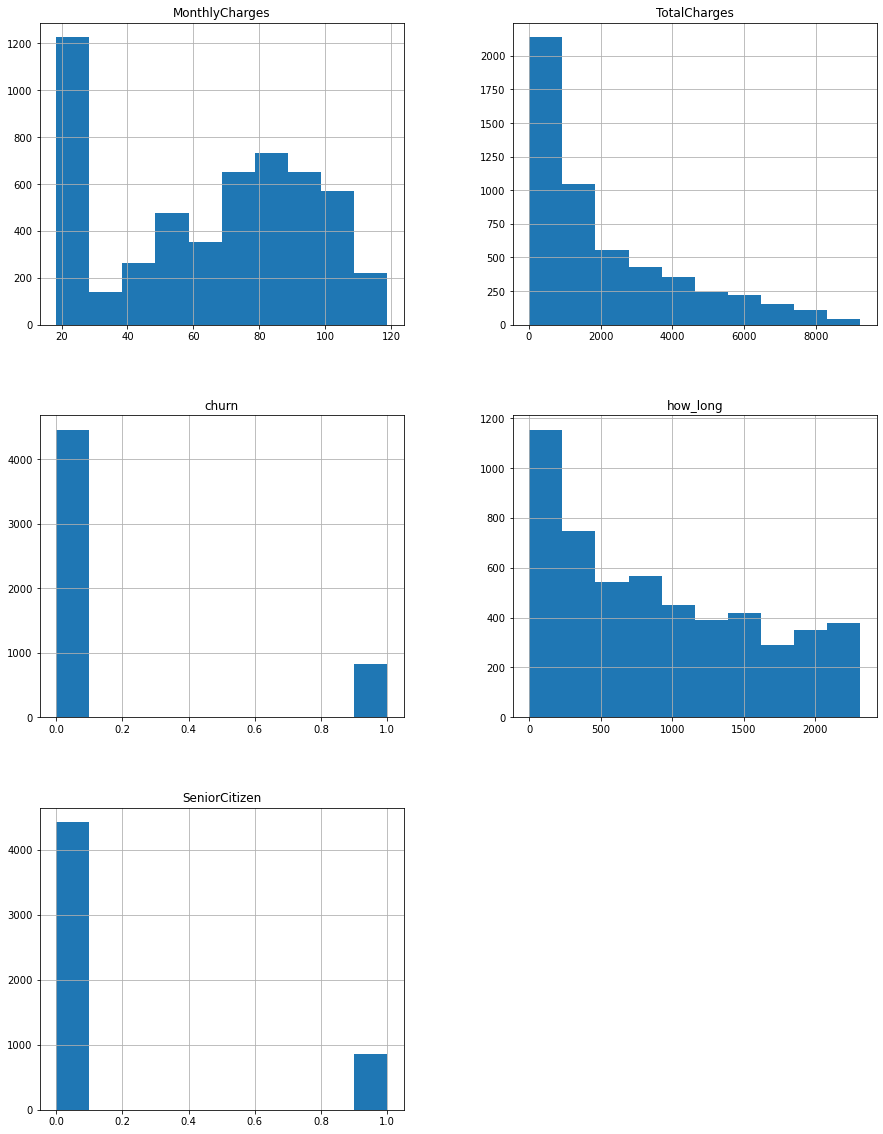

In [52]:
# построим гистограммы количественных признаков 
df_train.hist(figsize=(15, 20));

In [53]:
display(df_train.describe())

,MonthlyCharges,TotalCharges,churn,how_long,SeniorCitizen
count,5282.000000,5282.000000,5282.00000,5282.000000,5282.000000
mean,64.682753,2117.523287,0.15638,899.909504,0.162060
std,30.193444,2116.077532,0.36325,680.198949,0.368541
min,18.400000,19.050000,0.00000,0.000000,0.000000
25%,35.000000,440.650000,0.00000,276.000000,0.000000
50%,70.350000,1341.275000,0.00000,761.000000,0.000000
75%,89.850000,3260.865000,0.00000,1461.000000,0.000000
max,118.750000,9221.380000,1.00000,2314.000000,1.000000


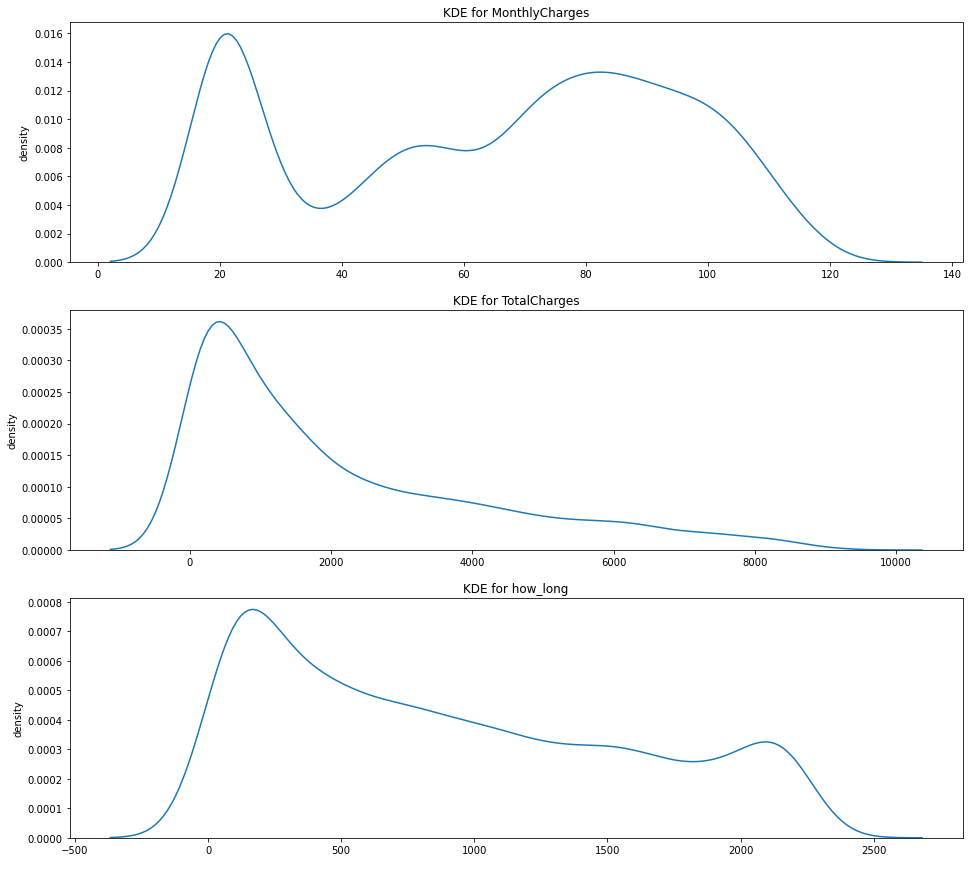

In [54]:
# построем KDE, чтобы посмотреть на распределения количественных признаков
i = 1
plt.figure(figsize=(16,15))
for col_name in ['MonthlyCharges', 'TotalCharges', 'how_long']:
        plt.subplot(3,1, i)
        sns.kdeplot(data=df_train, x=col_name)
        plt.xlabel(' ')
        plt.ylabel('density')
        plt.title(f"KDE for {col_name}")
        i += 1
plt.show()

У большого количества пользователей весьма скромная месячная оплата не больше 30 у.е. в месяц (вероятно, это означает, что у них мало дополнительных услуг). Если бы не они распределение напоминало нормалное, а так "многовершинное". Т.е. есть две "группы" пользователей, кто платят в месяц мало и кто - много.<br>
Тем не менее у большого количества пользоват небольшие общие расходы не более 2000 у.е. Распределение Пуассона. <br>
Большиое количество пользователей с оператором сравнительно не долго (не более 500 дней). Но есть и те, кто очень долго. (Поскольку данные за ок. 6 лет, трудно сказать, что долго, а что нет, данных по жизненному циклу пользователей нет). Также выделяются две "группы" пользователей: те кто долго и те, кто нет. <br>
В данные почти в 5 раз больше не-пенсионеров, чем пенсионеров.

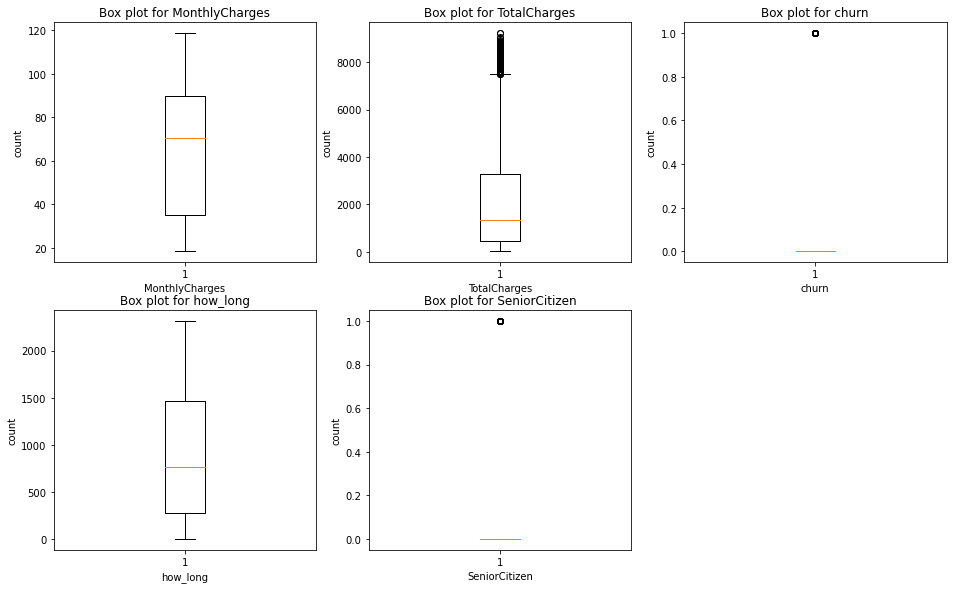

In [55]:
# проверим количественные признаки на аномалии по ящикам с усами

i = 1
plt.figure(figsize=(16,15))
for col_name in list(df_train.columns):
    if((df_train[col_name].dtypes=='int64' or df_train[col_name].dtypes=='float64') and col_name != 'charges'):
        plt.subplot(3,3, i)
        plt.boxplot(df_train[col_name])
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.title(f"Box plot for {col_name}")
        i += 1
plt.show()

'Аномалии' есть в `TotalCharges`. Т.к. датасет небольшой и других оснований считать их аномалиями нет, оставим. 

In [56]:
# удаление аномалий через цикл и IQR

outliers_features = ['TotalCharges']
for col_name in outliers_features:
    Q3 = df_train[col_name].quantile(0.75)
    Q1 = df_train[col_name].quantile(0.25)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    lower_limit = Q1 - 1.5*IQR
    prev_size = len(df_train)
    df_train = df_train[(df_train[col_name] >= lower_limit) & (df_train[col_name] <= upper_limit)]
    cur_size = len(df_train)
    print(f"удалили {prev_size - cur_size} строк в переменной {col_name}  с аномалиями")

удалили 135 строк в переменной TotalCharges  с аномалиями


Посмотрим как различаются распределение и разброс количественных признаков для ушедших и лояльных пользователей

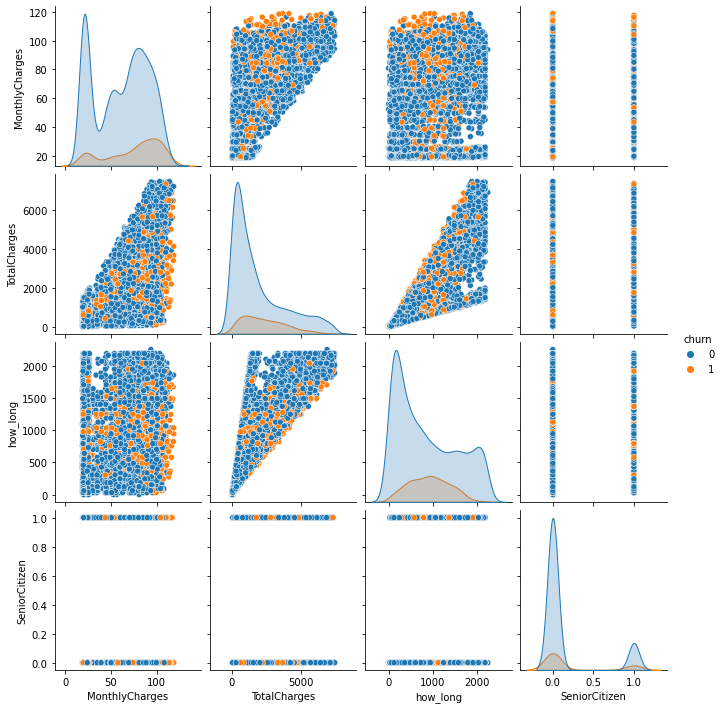

In [57]:
sns.pairplot(
    data=df_train, 
    aspect=.95,
    hue='churn')

Обращает внимание различие распределений в количестве дней, которое с оператором лояльные пользователи и ушедшие. У ушедших пользователей это нормальное распределение, а у лояльных "многовершинное", т.е. две группы - те кто уже очень долго с оператором и вряд ли вообще уйдут и те, кто присоединился недавно (и возможно в будущем периоде, за который нет данных, уйдут). <br><br>
Интересена диаграмма рассеяния между количеством дней и месячной платой. На ней видны 3 сегмента ушедших пользователей все они как правило с оператором от 500 до 1500 дней, но у одной группы песячная плата от 20 до 50 у.е., у другой от 70 до 100, у третьей - выше. (Вероятно, месячная плата тем выше, чем больше количество дополнительных услуг использовали). Те группы ушедших пользователей, у которых месячные платы выше смещены в сторону меньшего количества дней с оператором: 
у группы с месячными расходами от 70 до 100 - меньше 1000 дней, 
у группы с месяными расходами более 100 - ок. 500 дней.
<br><br>
Предположительно, ушедшие пользователи пробуют больше услуг (из-за чего месячная плата высокая) и быстрее уходят, лояльные используют меньше дополнительных услуг (из-за чего месячная плата сравнительно ниже) и остаются. 
<br><br>
Примечательно, что максимальные значения по месячной плате выше у тех пользователей, которые ушли, хотя общие расходы выше у лояльных пользователей.
<br><br>
<br><br>
Необходимо сравнение средних по количественным переменным для ушедших и лояльных пользователей. А также подсчет дополнительного количества услуг, которым они пользуются и изучения связи между ним и месячной платы. 

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Все верно, мы действительно видим, что ушедшие клиенты в среднем платили больше
    
</div>

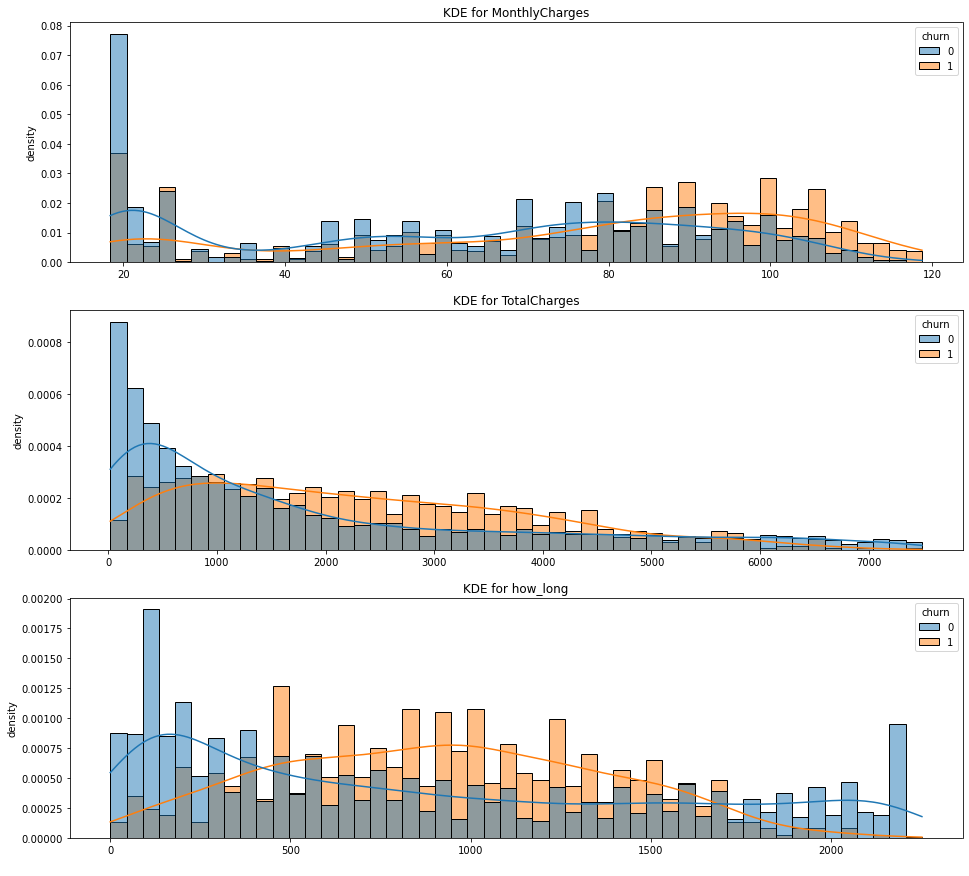

In [58]:
i = 1
plt.figure(figsize=(16,15))
for col_name in ['MonthlyCharges', 'TotalCharges', 'how_long']:
        plt.subplot(3,1, i)
        sns.histplot(data=df_train, 
                     x=col_name, 
                     hue='churn', 
                     bins=50, 
                     stat='density', 
                     kde=True, 
                     common_norm=False)
        plt.xlabel(' ')
        plt.ylabel('density')
        plt.title(f"KDE for {col_name}")
        i += 1
plt.show()

In [59]:
# таблица сопряженности по пользователям 
df_train.pivot_table(index='churn', values=['MonthlyCharges', 'TotalCharges', 'how_long',], aggfunc=['mean', 'median'])

mean                                  median               \
      MonthlyCharges TotalCharges    how_long MonthlyCharges TotalCharges   
churn                                                                       
0          61.263590  1889.515991  857.712237         67.250      1124.78   
1          75.000425  2333.180388  916.574029         84.125      2086.66   

                
      how_long  
churn           
0          671  
1          913

В среднем у ушедших пользователей месячная и общая плата были выше, чем у лояльных. (Они как будто бы и были дольше с оператором, но это из-за двух "групп" лояльных, которые в среднем дают меньшее значение). Необходимо проверять, являются ли различия средних статистически значимыми.(Поскольку распределения не нормальные, t-критерий не подойдет, только Манн-Уитни). Или ограничиться сравнением медиан. 

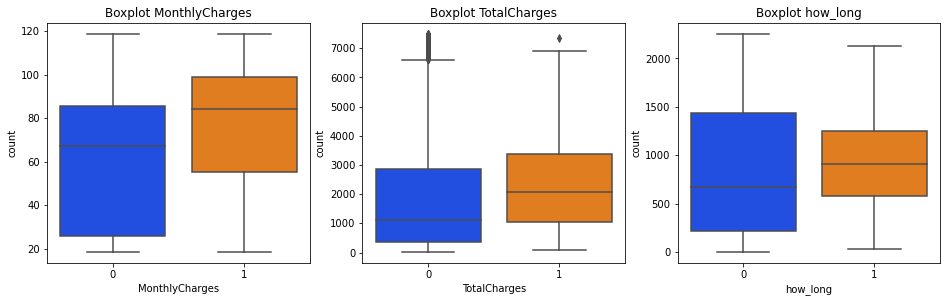

In [60]:
i = 1
plt.figure(figsize=(16,15))
for col_name in ['MonthlyCharges', 'TotalCharges', 'how_long']:
        plt.subplot(3,3, i)
        sns.boxplot(
                    x='churn', 
                    y=col_name, 
                    data=df_train,
                    palette='bright')
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.title(f"Boxplot {col_name}")
        i += 1
plt.show()

Ушедшие пользователи в среднем платят в месяц больше лояльных.

### Качественные признаки

Есть две основные услуги, из которых, вероятно, складывается основа месячной платы: MultipleLines и InternetService<br><br>
Дополнительные интернет-услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV	StreamingMovies, которые увеличивают месячную плату (от, допустим, базовой 30 у.е. до ок 100).<br><br>
Годовой метод оплаты, вероятно, несколько снижает месячную плату.

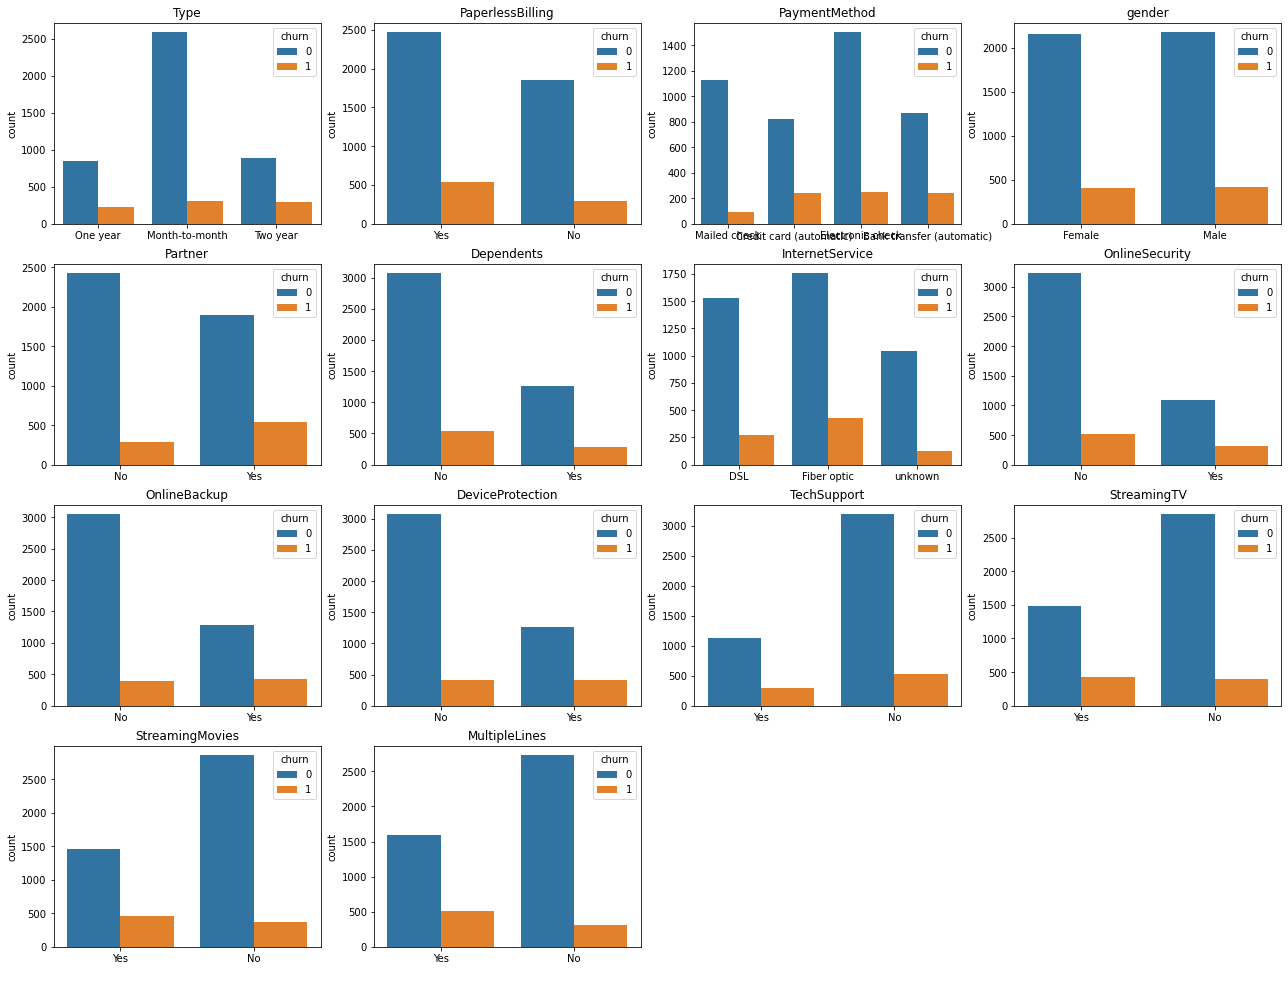

In [61]:
# посмотрим как различаются качественные признаки для ушедших и лояльных пользователей
i = 1
plt.figure(figsize=(22,17))
for col_name in list(df_train.columns):
    if(df_train[col_name].dtypes=='object'):
        plt.subplot(4,4, i)
        sns.countplot(x=col_name, hue='churn', data=df_train)
        plt.xlabel(' ')
        plt.ylabel('count')
        plt.title(f"{col_name}")
        i += 1
plt.show()

### Основные услуги

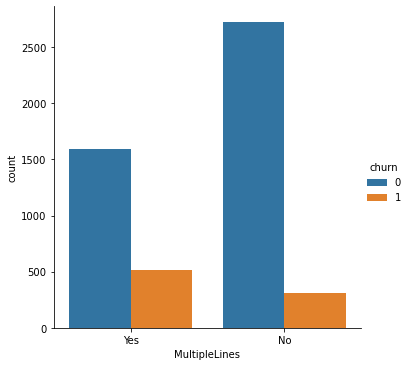

In [62]:
ax = sns.catplot(x ='MultipleLines', hue ='churn', kind ='count', data=df_train)

In [63]:
# выведем доли 
df_train.groupby('churn')['MultipleLines'].value_counts(normalize=True)

churn  MultipleLines
0      No               0.630812
       Yes              0.369188
1      Yes              0.625000
       No               0.375000
Name: MultipleLines, dtype: float64

**Среди ушедших пользователей больше доля тех, кто пользовался MultipleLines, а среди оставшихся тех, кто ей не пользовался. Обратное соотношение долей. (Вероятно, эта переменная будет важной)**.

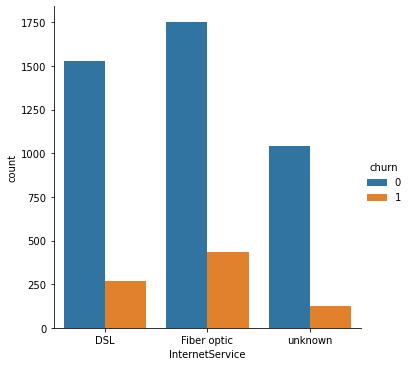

In [64]:
ax = sns.catplot(x ='InternetService', hue ='churn', kind ='count', data=df_train)

In [65]:
# выведем доли 
df_train.groupby('churn')['InternetService'].value_counts(normalize=True)

churn  InternetService
0      Fiber optic        0.405737
       DSL                0.353458
       unknown            0.240805
1      Fiber optic        0.524272
       DSL                0.325243
       unknown            0.150485
Name: InternetService, dtype: float64

**Доля ушедших пользователей, использующих оптоволоконный интернет больше аналогичной доли оставшихся**. Доля тех, кто не пользовался интернетом совсем среди ушедших пользователе (['InternetService'] == "unknown"), напротив меньше, чем аналогичной доли лояльных. <br><br>
Судя по использованию основных услуг ушедшие пользователи выглядят более технологически продвинутыми. Это подтверждает гипотезу о том, что их месячная плата выше посколько они перед уходом попробовали больше дополнительных интернет-услуг.

### Дополнительные интернет-услуги

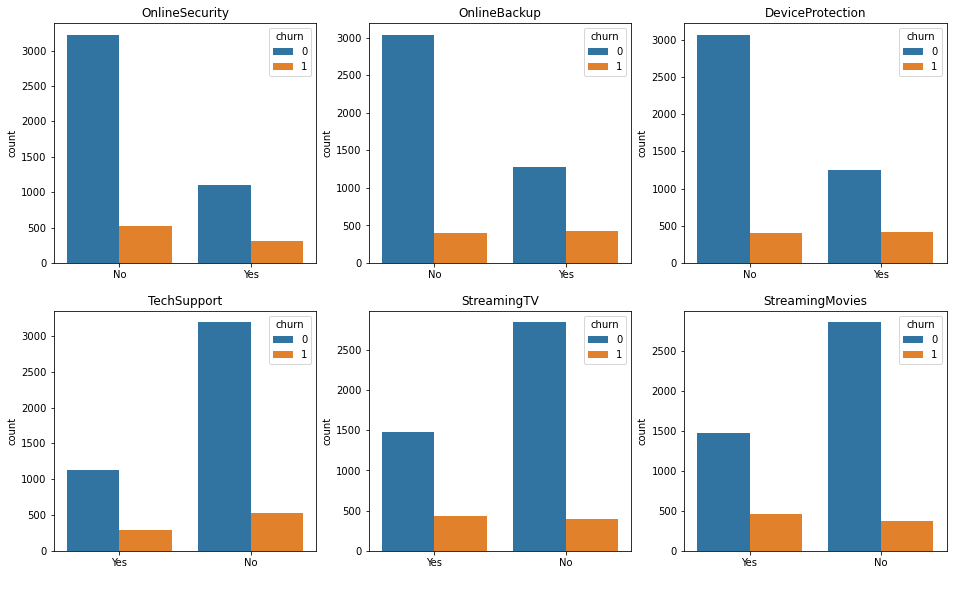

In [66]:
i = 1
plt.figure(figsize=(16,15))
for col_name in ['OnlineSecurity', 
                 'OnlineBackup', 
                 'DeviceProtection', 
                 'TechSupport', 
                 'StreamingTV', 
                 'StreamingMovies']:

        plt.subplot(3,3, i)
        sns.countplot(x=col_name, hue='churn', data=df_train)
        plt.xlabel(' ')
        plt.ylabel('count')
        plt.title(f"{col_name}")
        i += 1
plt.show()

In [67]:
for col_name in ['OnlineSecurity', 
                 'OnlineBackup', 
                 'DeviceProtection', 
                 'TechSupport', 
                 'StreamingTV', 
                 'StreamingMovies']:
    print(df_train.groupby('churn')[col_name].value_counts(normalize=True))
    print(df_train.groupby('churn')[col_name].value_counts())
    print()
    print()

churn  OnlineSecurity
0      No                0.746241
       Yes               0.253759
1      No                0.626214
       Yes               0.373786
Name: OnlineSecurity, dtype: float64
churn  OnlineSecurity
0      No                3226
       Yes               1097
1      No                 516
       Yes                308
Name: OnlineSecurity, dtype: int64


churn  OnlineBackup
0      No              0.704141
       Yes             0.295859
1      Yes             0.516990
       No              0.483010
Name: OnlineBackup, dtype: float64
churn  OnlineBackup
0      No              3044
       Yes             1279
1      Yes              426
       No               398
Name: OnlineBackup, dtype: int64


churn  DeviceProtection
0      No                  0.709692
       Yes                 0.290308
1      Yes                 0.504854
       No                  0.495146
Name: DeviceProtection, dtype: float64
churn  DeviceProtection
0      No                  3068
       Yes   

Наибольшие различия в долях пользователей среди ушедших и лояльных в следующих доп-услугах: OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies - лояльные чаще ими не пользовались, а ушедшие - пользовались.
<br><br>
Наибольшее различия в DeviceProtection и OnlineBackup, а StreamingTV и StreamingMovies в целом не слишком популярные услуги.
<br><br>
Доля ушедших пользователей пользовавшихся в целом популярными услугами OnlineSecurity и TechSupport меньше соответствующей доли лояльных. Что еще раз свидетельствует в пользу их большей технологической продвинутости. 

### Тип контракта и способ оплаты

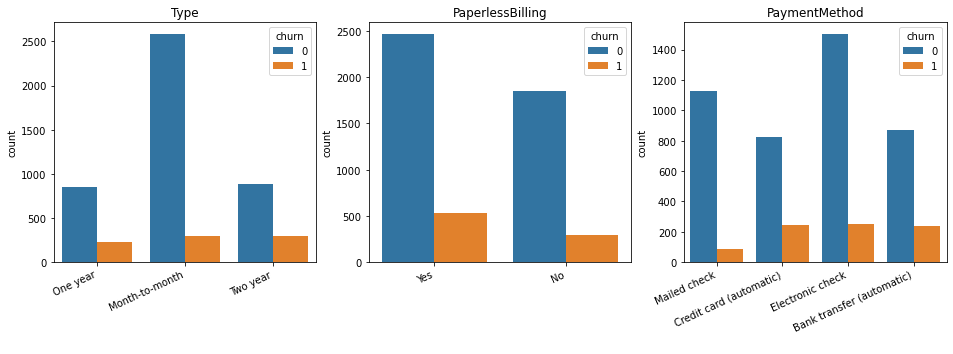

In [68]:
i = 1
plt.figure(figsize=(16,15))
for col_name in ['Type', 
                 'PaperlessBilling', 
                 'PaymentMethod']:

        plt.subplot(3,3, i)
        ax=sns.countplot(x=col_name, hue='churn', data=df_train)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
        plt.xlabel(' ')
        plt.ylabel('count')
        plt.title(f"{col_name}")
        i += 1
plt.show()

In [69]:
for col_name in ['Type', 
                 'PaperlessBilling', 
                 'PaymentMethod']:
    print(df_train.groupby('churn')[col_name].value_counts(normalize=True))
    print(df_train.groupby('churn')[col_name].value_counts())
    print()
    print()

churn  Type          
0      Month-to-month    0.598427
       Two year          0.204488
       One year          0.197085
1      Month-to-month    0.366505
       Two year          0.355583
       One year          0.277913
Name: Type, dtype: float64
churn  Type          
0      Month-to-month    2587
       Two year           884
       One year           852
1      Month-to-month     302
       Two year           293
       One year           229
Name: Type, dtype: int64


churn  PaperlessBilling
0      Yes                 0.571131
       No                  0.428869
1      Yes                 0.648058
       No                  0.351942
Name: PaperlessBilling, dtype: float64
churn  PaperlessBilling
0      Yes                 2469
       No                  1854
1      Yes                  534
       No                   290
Name: PaperlessBilling, dtype: int64


churn  PaymentMethod            
0      Electronic check             0.347907
       Mailed check                 0.2613

**Судя по долям, лояльные пользователи предпочитают месячную форму оплаты, а ушедшие - годовые (одно и двух).**<br>
Различий в предпочтениях к безналичному рассчету м-ду лояльными и ушедшими пользователями нет - и те, и другие предпочитают безналичный. <br>
Ярко выраженных различий в предпочтениях к способу оплаты м-ду лояльными и ушедшими нет: на первом месте по долям электронный чек. <br>
Суммарная доля тех, кто предпочитает автоплатеж с карты или счета (Credit card (automatic) + Bank transfer (automatic)) среди ушедших пользователей повыше (0.6), чем среди лояльных (0.4). В этом ушедшие пользователи также выглядят более технологически продвинутыми.  


Верно ли, что годовые тарифы по сравнению с месячными дают небольшую скидку в пересчете на месяц? 

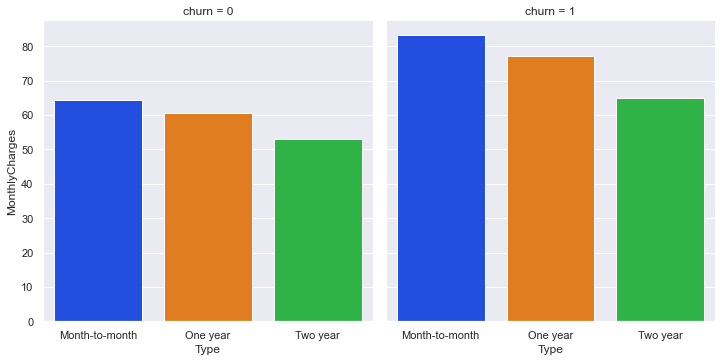

In [70]:
df_train_gr = df_train.groupby(['Type', 'churn'], as_index=False).agg({'MonthlyCharges': 'mean'})

sns.set(rc={'figure.figsize':(12,5)})

sns.catplot(
    x='Type', 
    y='MonthlyCharges',
    data=df_train_gr,
    palette='bright',
    kind = 'bar', 
    col='churn');

In [71]:
pivot_1 = df_train.pivot_table(index=['Type'], columns=['churn','MultipleLines','InternetService'], values='MonthlyCharges', aggfunc='mean')
print(pivot_1)

churn                    0                                                \
MultipleLines           No                               Yes               
InternetService        DSL Fiber optic    unknown        DSL Fiber optic   
Type                                                                       
Month-to-month   47.151601   81.464738  19.977949  61.346711   89.949649   
One year         57.253896   94.779688  19.963146  71.120192   99.800602   
Two year         62.760256   95.672973  19.961174  80.833648  100.554211   

churn                               1                                    \
MultipleLines                      No                               Yes   
InternetService    unknown        DSL Fiber optic    unknown        DSL   
Type                                                                      
Month-to-month   25.062500  50.180556   85.024390  19.725000  63.734375   
One year         24.865476  54.980208   93.198387  20.096875  73.165152   
Two year         

Самые большие расходы среди ушедших были у тех пользователей, которые пользовались всеми флагманскими услугами MultipleLines и оптоволоконный интернет вне зависимости от того был ли у них контракт на месячную, годовую или двухгодовую оплату. <br><br>
Примечательно, что чем дольше был срок контракта, тем больше в пересчете на месяц стоили флагманские услуги (для ушедших на месячной плате 95; на одногодичной 100; на двухгодичной - 106). Это сам по себе повод уйти.
<br><br>
Примерная стоимость основных услуг в месяц:
- MultipleLines ок 5 у.е.
- интерент если DSL ок 43 у.е.
- интернет если  Fiber optic ок 63 у.е.

Цена интернета зависит от того, сколько дополнительных интернет-услуг использовалось.

In [72]:
pivot_2 = df_train.pivot_table(index=['Type'], columns=['MultipleLines','InternetService'], values='churn', aggfunc='count')
print(pivot_2)

MultipleLines     No                      Yes                    
InternetService  DSL Fiber optic unknown  DSL Fiber optic unknown
Type                                                             
Month-to-month   741         689     358  168         900      33
One year         279         127     229  137         257      52
Two year         244          52     317  227         161     176


Больше всего ушедших пользователей среди тех, которые использовали услугу MultipleLines, оптоволоконный интернет и были на месячной оплате. Также большая группа ушедших, которые не пользовались услугой MultipleLines и не имели предпочтений к типу интернета (DSL + Fiber optic = 741 + 689).

### Соц-дем

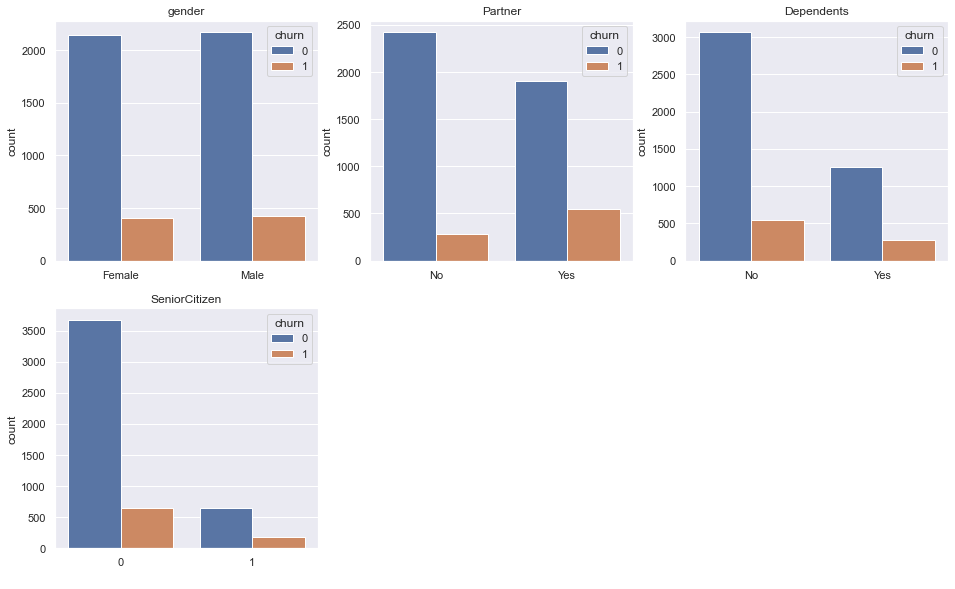

In [73]:
i = 1
plt.figure(figsize=(16,15))
for col_name in ['gender', 
                 'Partner', 
                 'Dependents',
                 'SeniorCitizen']:

        plt.subplot(3,3, i)
        sns.countplot(x=col_name, hue='churn', data=df_train)
        plt.xlabel(' ')
        plt.ylabel('count')
        plt.title(f"{col_name}")
        i += 1
plt.show()

In [74]:
for col_name in ['gender', 
                 'Partner', 
                 'Dependents',
                 'SeniorCitizen']:
    print(df_train.groupby('churn')[col_name].value_counts(normalize=True))
    print(df_train.groupby('churn')[col_name].value_counts())
    print()
    print()

churn  gender
0      Male      0.502892
       Female    0.497108
1      Male      0.510922
       Female    0.489078
Name: gender, dtype: float64
churn  gender
0      Male      2174
       Female    2149
1      Male       421
       Female     403
Name: gender, dtype: int64


churn  Partner
0      No         0.560490
       Yes        0.439510
1      Yes        0.658981
       No         0.341019
Name: Partner, dtype: float64
churn  Partner
0      No         2423
       Yes        1900
1      Yes         543
       No          281
Name: Partner, dtype: int64


churn  Dependents
0      No            0.709692
       Yes           0.290308
1      No            0.661408
       Yes           0.338592
Name: Dependents, dtype: float64
churn  Dependents
0      No            3068
       Yes           1255
1      No             545
       Yes            279
Name: Dependents, dtype: int64


churn  SeniorCitizen
0      0                0.849179
       1                0.150821
1      0           

Соц-дем. портрет ушедших(судя по долям): Чаще с партнером, (несколько чаще с детьми по сравнению с лояльными) без детей и (несколько чаще пенсионеры по сравнению с лояльными) не-пенсионеры.<br><br>
Соц-дем. портрет лояльных(судя по долям): Чаще одинокие, несколько реже с детьми и пенсионеры.

### Перекодируем динарные признаки и сравним количество доп услуг у ушедших и лояльных

In [75]:
# не будем использовать параметр  drop_first=True, чтобы все доп-услуги остались на месте
df_train_dumm = pd.get_dummies(df_train, drop_first=True)

In [76]:
# посмотрим
display(df_train_dumm.head())

,BeginDate,EndDate,MonthlyCharges,TotalCharges,churn,how_long,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,...,Dependents_Yes,InternetService_Fiber optic,InternetService_unknown,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
4123-FCVCB,2019-02-01,2020-02-01,75.85,946.61,0,365,0,1,0,1,...,0,0,0,0,0,0,1,1,1,1
5569-OUICF,2017-09-01,2020-02-01,101.30,2937.70,0,883,1,0,0,1,...,0,1,0,0,0,0,1,1,1,1
0750-EBAIU,2015-10-01,2019-12-01,91.25,4973.12,1,1522,0,1,0,0,...,0,1,0,1,0,1,0,1,0,0
2190-BCXEC,2016-10-01,2020-02-01,78.85,3217.08,0,1218,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
2987-BJXIK,2014-04-01,2018-08-01,84.70,4404.40,1,1583,0,0,1,0,...,0,0,0,1,1,1,0,1,1,1


In [77]:
print(df_train_dumm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5147 entries, 4123-FCVCB to 3606-SBKRY
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   BeginDate                              5147 non-null   datetime64[ns]
 1   EndDate                                5147 non-null   datetime64[ns]
 2   MonthlyCharges                         5147 non-null   float64       
 3   TotalCharges                           5147 non-null   float64       
 4   churn                                  5147 non-null   int64         
 5   how_long                               5147 non-null   int64         
 6   SeniorCitizen                          5147 non-null   int64         
 7   Type_One year                          5147 non-null   uint8         
 8   Type_Two year                          5147 non-null   uint8         
 9   PaperlessBilling_Yes                   5147 non-null 

In [78]:
col_dop = ['OnlineSecurity_Yes', 
           'OnlineBackup_Yes', 
           'DeviceProtection_Yes', 
           'TechSupport_Yes', 
           'StreamingTV_Yes', 
           'StreamingMovies_Yes']


df_train_dumm[col_dop] = df_train_dumm[col_dop].astype('int')

df_train_dumm['serv_nubm'] = df_train_dumm[col_dop].sum(axis=1)

In [79]:
df_train_dumm.pivot_table(index='churn', values=['MonthlyCharges', 'serv_nubm'], aggfunc=['mean', 'median', 'max', 'min'])

mean                   median                      max  \
      MonthlyCharges serv_nubm MonthlyCharges serv_nubm MonthlyCharges   
churn                                                                    
0          61.263590  1.783715         67.250         1         118.60   
1          75.000425  2.827670         84.125         3         118.75   

                           min            
      serv_nubm MonthlyCharges serv_nubm  
churn                                     
0             6          18.55         0  
1             6          18.40         0

In [80]:
print('корреляция м-ду месячной платой и количеством доп. услуг:', round(df_train_dumm['MonthlyCharges'].corr(df_train_dumm['serv_nubm']), 2))

корреляция м-ду месячной платой и количеством доп. услуг: 0.71


Ушедшие пользователи в среднем и по медиане действительно пользовались большим количеством доп. интернет-услуг и в том числе поэтому их ежемесячная плата была больше.
<br><br>
Можно вычислить пременую стоимость каждой доп услуги в месяц для каждого типа интернета, сравнивая с помощтю срезов, сколько платит в месяц пользователь с таким типом интернета и такой доп услугой при прочих равных по сравнению с пользователем с теким типом интернета, у которого нет ни одной услуги.
<br><br>
Количество доп. услуг также можно было бы использовать в качестве признака (но это добавляет проблему мультиколлинеарности).

In [81]:
# срез для ушедших посмотрим сколько дней в среднем они оставались и сколько платили в месц в зависимости от количества услуг
df_train_dumm.loc[df_train_dumm['churn'] == 1].pivot_table(index='serv_nubm', values=['how_long', 'MonthlyCharges'], aggfunc=['mean'])



mean             
          MonthlyCharges     how_long
serv_nubm                            
0              28.530345   921.393103
1              69.997143   723.800000
2              74.934434   880.047170
3              81.980791   858.406780
4              91.378834   927.441718
5              92.209292  1061.318584
6              99.912000  1093.280000

In [82]:
dumm_gr = df_train_dumm.groupby(['serv_nubm', 
                                 'OnlineSecurity_Yes', 
                                 'OnlineBackup_Yes', 
                                'DeviceProtection_Yes', 
                                'TechSupport_Yes', 
                                'StreamingTV_Yes', 
                                'StreamingMovies_Yes'], as_index=False).agg({'MonthlyCharges': 'mean'})

display(dumm_gr.head(12))



,serv_nubm,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MonthlyCharges
0,0,0,0,0,0,0,0,32.328370
1,1,0,0,0,0,0,1,73.807914
2,1,0,0,0,0,1,0,74.112963
3,1,0,0,0,1,0,0,54.403704
4,1,0,0,1,0,0,0,64.331053
5,1,0,1,0,0,0,0,63.045066
6,1,1,0,0,0,0,0,59.954365
7,2,0,0,0,0,1,1,86.182622
8,2,0,0,0,1,0,1,72.489474
9,2,0,0,0,1,1,0,73.518182


### Портрет ушедшего пользователя

- Не-пенсионер с партнером без детей;
- Технологически продвинут:
    - пробовал флагманские услуги (MultipleLines и оптоволоконный интернет, редко не пользуется интернетом вообще);
    - пробовал ок. 3-х доп. интернет-услуг (вероятно из числа OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies);
    - OnlineSecurity и TechSupport не пользуется;
    - на годовой или двухгодовой оплате из экономии чуть чаще чем на месячной;
    - тем не менее в месяц за пробование дополнительных услуг платит сранвительно много - в среднем 75 у.е. (но есть две группы - те кто платят больше, ок 100 и используют больше доп услуг и быстрее уходят и те, кто платят меньше, ок 30 и уходят медленне);
    - предпочитает безналичный способ оплаты (электронным чеком или автоплатежем с банковской карты или счета);
    - чем больше доп. услуг успел попробовать, тем быстрее уходит;
- в среднем с оператором ок. 1000 дней.


## Мультиколлинеарность и важность признаков

Для обнаружения мультиколлинеарности используем фи-корреляцию, которая подходит для смешаного набора признаков и не чувствительна к выбросам.

In [83]:
# матрица корреляций phik
phik_overview = df.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'churn', 'how_long', 'SeniorCitizen']


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,how_long,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
BeginDate,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.45,0.98,0.01,...,0.47,0.21,0.19,0.40,0.45,0.46,0.40,0.36,0.37,0.43
EndDate,0.55,1.00,0.29,0.06,0.17,0.17,0.22,1.00,0.40,0.02,...,0.18,0.06,0.12,0.13,0.20,0.20,0.11,0.16,0.18,0.21
Type,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.09,0.63,0.00,...,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07
PaperlessBilling,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.08,0.03,0.00,...,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25
PaymentMethod,0.46,0.17,0.28,0.37,1.00,0.40,0.34,0.21,0.35,0.00,...,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34
MonthlyCharges,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.23,0.39,0.01,...,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68
TotalCharges,0.77,0.22,0.47,0.20,0.34,0.71,1.00,0.30,0.85,0.00,...,0.38,0.08,0.49,0.52,0.62,0.64,0.55,0.64,0.64,0.57
churn,0.45,1.00,0.09,0.08,0.21,0.23,0.30,1.00,0.37,0.01,...,0.23,0.05,0.06,0.13,0.23,0.22,0.10,0.20,0.22,0.26
how_long,0.98,0.40,0.63,0.03,0.35,0.39,0.85,0.37,1.00,0.00,...,0.45,0.20,0.06,0.40,0.41,0.43,0.40,0.34,0.34,0.40
gender,0.01,0.02,0.00,0.00,0.00,0.01,0.00,0.01,0.00,1.00,...,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00


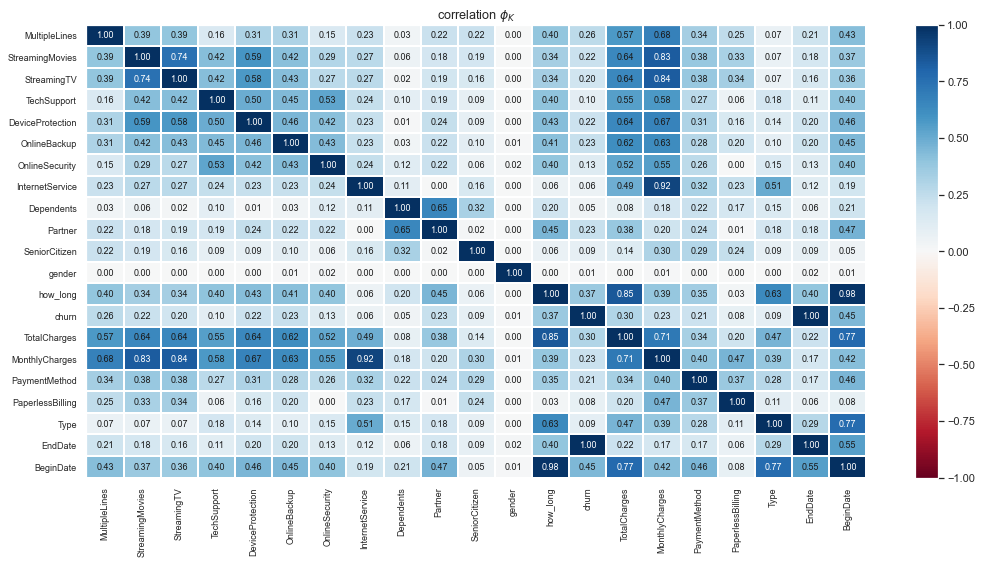

In [84]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=-1, vmax=1, color_map="RdBu", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.9, 
                        figsize=(15, 8))
plt.tight_layout()

У `MonthlyCharges` ожидаемо высокая фи-корреляция с `InternetService` (0.92) и дополнительными услугами, особенно `StreamingMovies` (0.83), `StreamingTV` (0.84) (вероятно, особенно дорогие доп. услуги). <br><br>
у `TotalCharges` высокая корреляция с `how_long` (0.85) и `MonthlyCharges` (0.71). <br><br>
Корреляция `churn` c `TotalCharges` (0.3) несколько больше, чем с `MonthlyCharges` (0.23). <br><br>
`BeginDate` и `EndDate` будут удалены, чтобы избежать "утечки целевого признака". <br><br>
Для деревянных и бустинговых моделей мультиколлинеарность не страшна, поэтому удалять признаки пока не буду. 


**Посмотрим на важность признаков с помощью mutual_info_classif**

In [85]:
# фичи
X = df_train.copy()
X = X.drop(['BeginDate', 'EndDate'], axis=1) # удалили тип datetime64, который не подходит
# таргет
y = X.pop("churn")

# перекодируем переменные типа "object" 
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# все переменные для mutual_info_classif должны быть типа int  
discrete_features = X.dtypes == int

In [86]:


# создали функцию для получения оценки важности признаков
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # показать несколько с оценкой важности

how_long            0.284444
Type                0.015048
DeviceProtection    0.013386
MonthlyCharges      0.011875
OnlineSecurity      0.004637
PaperlessBilling    0.001661
Name: MI Scores, dtype: float64

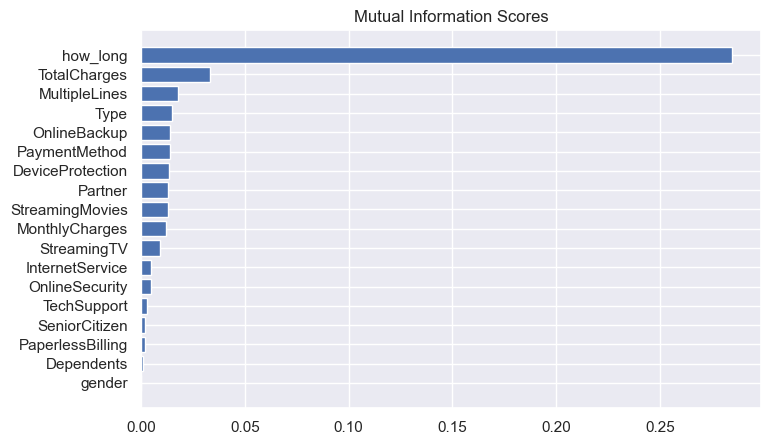

In [87]:
# функция для графика важности признаков
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Если бы требование избавиться от мультиколлинеарности для модели логистической регресси было жестким, то удалил бы `MonthlyCharges`. Но все равно останется высокая фи-корреляция `TotalCharges` с `how_long` (0.85).<br> Для борьбы с мультиколлинеарностью можно было бы использовать снижение размерности, тогда скоррелированные признаки можно не удалять.

## Подготовка данных для модели

In [88]:
# разделим на фичи и таргет
features_train = df_train.drop(['churn', 'BeginDate', 'EndDate'], axis=1)
target_train = df_train['churn']

features_test = df_test.drop(['churn', 'BeginDate', 'EndDate'], axis=1)
target_test = df_test['churn']

In [89]:
print(features_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5147 entries, 4123-FCVCB to 3606-SBKRY
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5147 non-null   object 
 1   PaperlessBilling  5147 non-null   object 
 2   PaymentMethod     5147 non-null   object 
 3   MonthlyCharges    5147 non-null   float64
 4   TotalCharges      5147 non-null   float64
 5   how_long          5147 non-null   int64  
 6   gender            5147 non-null   object 
 7   SeniorCitizen     5147 non-null   int64  
 8   Partner           5147 non-null   object 
 9   Dependents        5147 non-null   object 
 10  InternetService   5147 non-null   object 
 11  OnlineSecurity    5147 non-null   object 
 12  OnlineBackup      5147 non-null   object 
 13  DeviceProtection  5147 non-null   object 
 14  TechSupport       5147 non-null   object 
 15  StreamingTV       5147 non-null   object 
 16  StreamingMovies   5147 non-null 

In [90]:
# список категориальных переменных (для кодирования)
cat_features = features_train.select_dtypes(include='object').columns.to_list()
# список количественных переменных (для шкалирования)
num_features = ['MonthlyCharges', 'TotalCharges', 'how_long']

## get_dummies

In [91]:
# получим dummies для features_train избегая ошибки 
features_train_dumm = pd.get_dummies(features_train, drop_first=True)

In [92]:
display(features_train_dumm.head())

,MonthlyCharges,TotalCharges,how_long,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_unknown,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
4123-FCVCB,75.85,946.61,365,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,1,1,1
5569-OUICF,101.30,2937.70,883,1,0,0,1,1,0,0,...,0,1,0,0,0,0,1,1,1,1
0750-EBAIU,91.25,4973.12,1522,0,1,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2190-BCXEC,78.85,3217.08,1218,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
2987-BJXIK,84.70,4404.40,1583,0,0,1,0,0,0,1,...,0,0,0,1,1,1,0,1,1,1


In [93]:
print(features_train_dumm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5147 entries, 4123-FCVCB to 3606-SBKRY
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         5147 non-null   float64
 1   TotalCharges                           5147 non-null   float64
 2   how_long                               5147 non-null   int64  
 3   SeniorCitizen                          5147 non-null   int64  
 4   Type_One year                          5147 non-null   uint8  
 5   Type_Two year                          5147 non-null   uint8  
 6   PaperlessBilling_Yes                   5147 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  5147 non-null   uint8  
 8   PaymentMethod_Electronic check         5147 non-null   uint8  
 9   PaymentMethod_Mailed check             5147 non-null   uint8  
 10  gender_Male                            5147 non-null   uint8  

In [94]:
# получаем dummies для features_test избегая ошибки 
features_test_dumm = pd.get_dummies(features_test, drop_first=True)

In [95]:
print(features_test_dumm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1761 entries, 4694-PHWFW to 5297-MDOIR
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   MonthlyCharges                         1761 non-null   float64
 1   TotalCharges                           1761 non-null   float64
 2   how_long                               1761 non-null   int64  
 3   SeniorCitizen                          1761 non-null   int64  
 4   Type_One year                          1761 non-null   uint8  
 5   Type_Two year                          1761 non-null   uint8  
 6   PaperlessBilling_Yes                   1761 non-null   uint8  
 7   PaymentMethod_Credit card (automatic)  1761 non-null   uint8  
 8   PaymentMethod_Electronic check         1761 non-null   uint8  
 9   PaymentMethod_Mailed check             1761 non-null   uint8  
 10  gender_Male                            1761 non-null   uint8  

In [96]:
# проверим, чтобы имена новых переменных совпадали в обучающей и тестовой выборке

# список имен переменнных eatures_train_dumm
col_names_train = features_train_dumm.columns.tolist()
# список имен переменнных features_test_dumm 
col_names_test = features_test_dumm.columns.tolist()

unique_name = []

for n in col_names_train:
    if n not in col_names_test:
        unique_name.append(n)

print(unique_name)

[]


Список пустой, значит все имена переменных совпадают. Отмасштабируем количественные признаки.

In [97]:
# масштабирование
scaler = StandardScaler()
features_train_dumm[num_features] = scaler.fit_transform(features_train_dumm[num_features])
features_test_dumm[num_features] = scaler.transform(features_test_dumm[num_features])

In [98]:
# посмотрим
display(features_train_dumm.head())

,MonthlyCharges,TotalCharges,how_long,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_unknown,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
4123-FCVCB,0.418366,-0.532489,-0.763499,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,1,1,1
5569-OUICF,1.277913,0.513175,0.024122,1,0,0,1,1,0,0,...,0,1,0,0,0,0,1,1,1,1
0750-EBAIU,0.938485,1.582120,0.995723,0,1,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
2190-BCXEC,0.519688,0.659897,0.533490,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,1
2987-BJXIK,0.717265,1.283444,1.088474,0,0,1,0,0,0,1,...,0,0,0,1,1,1,0,1,1,1


## Обучение и валидация модели

In [99]:
# функция для подбора гиперпараметров

def model_searcher (model, parametrs, features_train, target_train):
    
    # создан подборщик гиперпараметров
    r_search = RandomizedSearchCV(model, 
                                  parametrs, 
                                  cv=3, 
                                  scoring='roc_auc',
                                  random_state=RANDOM_STATE,
                                  n_iter=100,
                                  verbose=1,
                                  n_jobs=-1)
    
    # обучен подборщик гиперпараметров
    r_search.fit(features_train, target_train)
    
    # лучшие параметры
    best_params = r_search.best_params_
    
    #cv_results_ в таблицу
    results = pd.DataFrame(r_search.cv_results_)
    # сохранили индекс лучшей модели
    best_index = r_search.best_index_
    
    # сохранили время обучения лучшей модели
    fit_time = round((results['mean_fit_time'].iloc[best_index]), 2)
    # сохранили время предсказания лучшей модели
    score_time = round((results['mean_score_time'].iloc[best_index]), 2)
    # сохранили ROC_AUC лучшей модели по модулю, т.к. scoring='roc_auc' 
    ROC_AUC = round((abs(results['mean_test_score'].iloc[best_index])), 2)
    
    return (best_params, fit_time, score_time, ROC_AUC)

### DecisionTreeClassifier

In [100]:
model_0 = DecisionTreeClassifier(class_weight='balanced')

In [101]:
parametrs_0 = { 'criterion': ['gini', 'entropy', 'log_loss'],
                'max_depth': range (2,20, 2) }

In [102]:
# подберем гиперпараметры для features_train_dumm (перекодированных OHE)

best_params_0, fit_time_0, score_time_0, ROC_AUC_0 = model_searcher(model_0, 
                                                                 parametrs_0, 
                                                                 features_train_dumm, 
                                                                 target_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:    2.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    2.7s finished


In [103]:
print('model_0 - DecisionTreeClassifier:')
print(f"лучшие гиперпараметры: {best_params_0}")
print(f"ROC_AUC: {ROC_AUC_0}")
print(f"время обучения: {fit_time_0} сек.")
print(f"время предсказания: {score_time_0} сек.")

model_0 - DecisionTreeClassifier:
лучшие гиперпараметры: {'max_depth': 6, 'criterion': 'gini'}
ROC_AUC: 0.78
время обучения: 0.03 сек.
время предсказания: 0.01 сек.


### RandomForestClassifier

In [104]:
# модель (+баланс классов) и параметры 

model_1 = RandomForestClassifier(class_weight='balanced')
parametrs_1 = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1,11, 1) }

In [105]:
# подберем гиперпараметры для features_train_dumm (перекодированных OHE)

best_params_1, fit_time_1, score_time_1, ROC_AUC_1 = model_searcher(model_1, 
                                                                 parametrs_1, 
                                                                 features_train_dumm, 
                                                                 target_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:   25.7s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.6s finished


In [106]:
print('model_1 - RandomForestClassifier:')
print(f"лучшие гиперпараметры: {best_params_1}")
print(f"ROC_AUC: {ROC_AUC_1}")
print(f"время обучения: {fit_time_1} сек.")
print(f"время предсказания: {score_time_1} сек.")

model_1 - RandomForestClassifier:
лучшие гиперпараметры: {'n_estimators': 50, 'max_depth': 6}
ROC_AUC: 0.82
время обучения: 0.28 сек.
время предсказания: 0.03 сек.


### CatBoostClassifier

Хотя для ROC-AUC баланс классов не важен, создадим модель с балансом классов, т.к. для accuracy он важен.

In [108]:
# баланс классов для Catboost
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

In [109]:
model_2 = CatBoostClassifier(loss_function="Logloss",
                             class_weights=class_weights)

parametrs_2 = { 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
               'iterations': [10, 50, 100, 200, 500],
               'depth': [2,3] }

In [110]:
# подберем гиперпараметры для features_train_dumm 

best_params_2, fit_time_2, score_time_2, ROC_AUC_2 = model_searcher(model_2, 
                                                                 parametrs_2, 
                                                                 features_train_dumm, 
                                                                 target_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   34.3s finished


0:	learn: 0.6437932	total: 65.7ms	remaining: 32.8s
1:	learn: 0.6052485	total: 68.4ms	remaining: 17s
2:	learn: 0.5798640	total: 70.5ms	remaining: 11.7s
3:	learn: 0.5569751	total: 72.6ms	remaining: 9s
4:	learn: 0.5440434	total: 76.1ms	remaining: 7.53s
5:	learn: 0.5338623	total: 78.8ms	remaining: 6.49s
6:	learn: 0.5229845	total: 80.7ms	remaining: 5.68s
7:	learn: 0.5175705	total: 82.5ms	remaining: 5.08s
8:	learn: 0.5140525	total: 85.2ms	remaining: 4.65s
9:	learn: 0.5098067	total: 87.6ms	remaining: 4.29s
10:	learn: 0.5077333	total: 89.8ms	remaining: 3.99s
11:	learn: 0.5026395	total: 91.9ms	remaining: 3.74s
12:	learn: 0.4978087	total: 93.7ms	remaining: 3.51s
13:	learn: 0.4951121	total: 95.8ms	remaining: 3.33s
14:	learn: 0.4938603	total: 98.1ms	remaining: 3.17s
15:	learn: 0.4919300	total: 100ms	remaining: 3.03s
16:	learn: 0.4893081	total: 102ms	remaining: 2.9s
17:	learn: 0.4877916	total: 104ms	remaining: 2.79s
18:	learn: 0.4868770	total: 111ms	remaining: 2.8s
19:	learn: 0.4850822	total: 113ms

197:	learn: 0.2435623	total: 579ms	remaining: 884ms
198:	learn: 0.2426923	total: 582ms	remaining: 881ms
199:	learn: 0.2423775	total: 585ms	remaining: 877ms
200:	learn: 0.2417825	total: 587ms	remaining: 873ms
201:	learn: 0.2411789	total: 589ms	remaining: 869ms
202:	learn: 0.2407616	total: 591ms	remaining: 865ms
203:	learn: 0.2403104	total: 593ms	remaining: 861ms
204:	learn: 0.2396326	total: 595ms	remaining: 856ms
205:	learn: 0.2386859	total: 597ms	remaining: 853ms
206:	learn: 0.2382524	total: 600ms	remaining: 849ms
207:	learn: 0.2379461	total: 606ms	remaining: 851ms
208:	learn: 0.2378516	total: 610ms	remaining: 850ms
209:	learn: 0.2373229	total: 612ms	remaining: 846ms
210:	learn: 0.2369504	total: 616ms	remaining: 844ms
211:	learn: 0.2367804	total: 621ms	remaining: 844ms
212:	learn: 0.2362432	total: 624ms	remaining: 841ms
213:	learn: 0.2358575	total: 626ms	remaining: 837ms
214:	learn: 0.2354731	total: 628ms	remaining: 833ms
215:	learn: 0.2350480	total: 630ms	remaining: 829ms
216:	learn: 

415:	learn: 0.1564002	total: 1.3s	remaining: 262ms
416:	learn: 0.1562106	total: 1.3s	remaining: 259ms
417:	learn: 0.1557759	total: 1.3s	remaining: 256ms
418:	learn: 0.1554720	total: 1.31s	remaining: 253ms
419:	learn: 0.1551919	total: 1.31s	remaining: 250ms
420:	learn: 0.1549231	total: 1.31s	remaining: 246ms
421:	learn: 0.1546770	total: 1.32s	remaining: 244ms
422:	learn: 0.1544203	total: 1.32s	remaining: 241ms
423:	learn: 0.1541441	total: 1.33s	remaining: 238ms
424:	learn: 0.1537995	total: 1.33s	remaining: 235ms
425:	learn: 0.1536732	total: 1.33s	remaining: 232ms
426:	learn: 0.1535642	total: 1.34s	remaining: 229ms
427:	learn: 0.1533378	total: 1.34s	remaining: 226ms
428:	learn: 0.1531507	total: 1.34s	remaining: 223ms
429:	learn: 0.1530381	total: 1.35s	remaining: 220ms
430:	learn: 0.1527397	total: 1.36s	remaining: 218ms
431:	learn: 0.1523885	total: 1.36s	remaining: 215ms
432:	learn: 0.1515010	total: 1.37s	remaining: 212ms
433:	learn: 0.1513875	total: 1.37s	remaining: 208ms
434:	learn: 0.1

In [111]:
print('model_2 - CatBoostClassifier:')
print(f"лучшие гиперпараметры: {best_params_2}")
print(f"ROC_AUC: {ROC_AUC_2}")
print(f"время обучения: {fit_time_2} сек.")
print(f"время предсказания: {score_time_2} сек.")

model_2 - CatBoostClassifier:
лучшие гиперпараметры: {'learning_rate': 0.3, 'iterations': 500, 'depth': 3}
ROC_AUC: 0.91
время обучения: 1.19 сек.
время предсказания: 0.01 сек.


In [112]:
# создадим модель с лучшими гиперпараметрами

model_2 = CatBoostClassifier(loss_function="Logloss",
                             class_weights=class_weights,
                             learning_rate=0.3,
                             iterations=500,
                             depth=2
                            )

In [113]:
#Обучим модель
model_2.fit(features_train_dumm, target_train, verbose=100)

0:	learn: 0.6594442	total: 1.44ms	remaining: 721ms
100:	learn: 0.4001833	total: 313ms	remaining: 1.24s
200:	learn: 0.3083939	total: 638ms	remaining: 949ms
300:	learn: 0.2633838	total: 877ms	remaining: 580ms
400:	learn: 0.2363328	total: 1.27s	remaining: 314ms
499:	learn: 0.2164162	total: 1.46s	remaining: 0us


In [114]:
# посмотрим на Accuracy лучшей модели на обучающей выборке

result = model_2.score(features_train_dumm, target_train)
print("Accuracy лучшей модели на обучающей выборке:", round((result),2))

Accuracy лучшей модели на обучающей выборке: 0.93


In [115]:
# посмотрим на важность признаков важность признаков
model_2.get_feature_importance(prettified=True)

,Feature Id,Importances
0,how_long,77.584589
1,TotalCharges,7.257395
2,MonthlyCharges,4.124304
3,Type_Two year,2.098215
4,MultipleLines_Yes,1.552354
5,Partner_Yes,1.407847
6,OnlineBackup_Yes,0.849465
7,Type_One year,0.829310
8,DeviceProtection_Yes,0.784759
9,StreamingMovies_Yes,0.755518


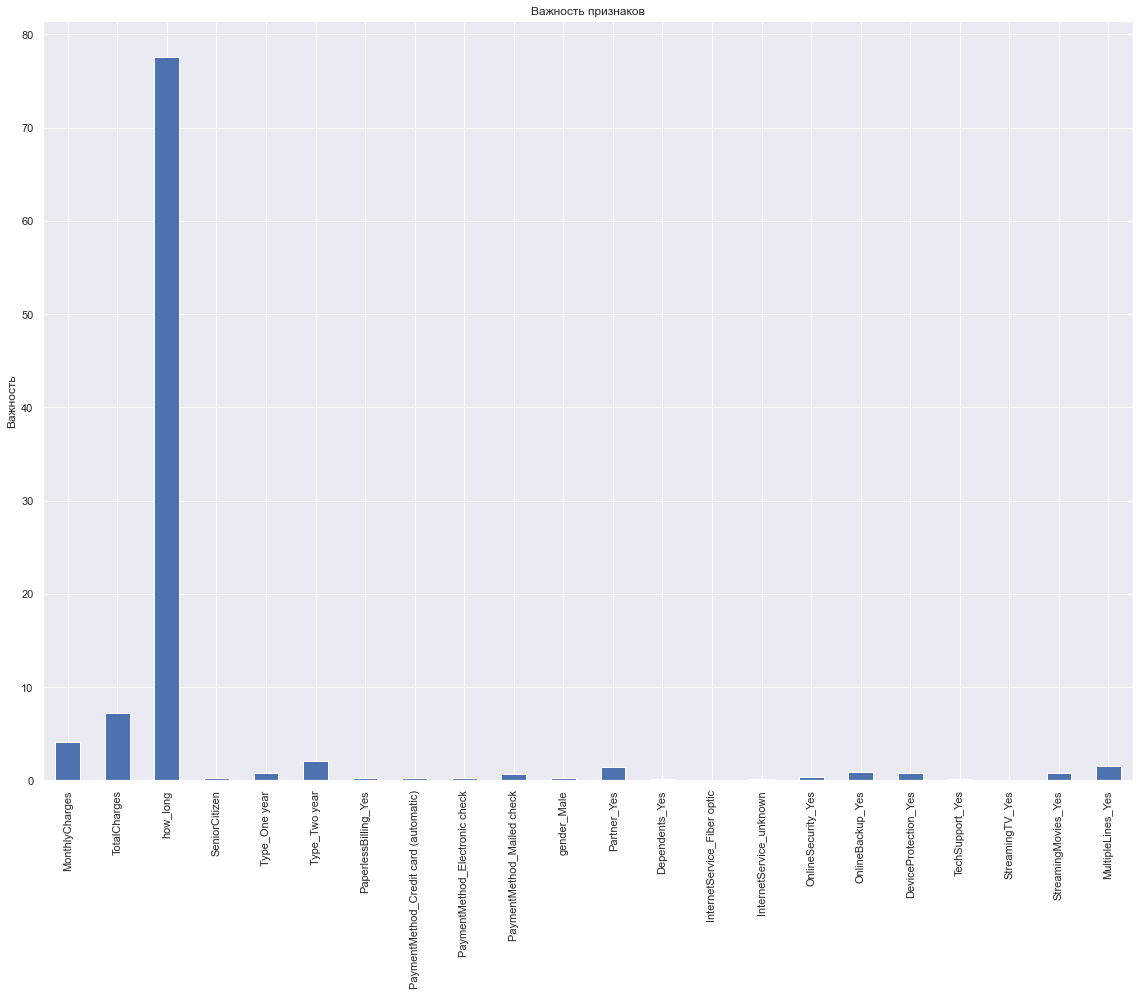

In [116]:
# график важности признаков 
f_imp = pd.Series(model_2.feature_importances_, features_train_dumm.columns)

fig, ax = plt.subplots(figsize=(16,14))
f_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

Между предварительной важностью признаков согласно mutual_info_classif и фактической для CatBoostClassifier, есть некоторые расхождения топ-5 важных признаков м-ду рангами (хотя список один и тот же) `MonthlyCharges` `MultipleLines` и `Type`: на первом месте у обоих `how_long`, на втором - `TotalCharges`, для mutual_info_classif важнее `MultipleLines`, а для CatBoostClassifier - `MonthlyCharges`, на четвертом месте `Type`.      

### Тестирование лучшей модели

In [117]:
# посмотрим на ROC-AUC модели на тестовой выборке

probabilities_test = model_2.predict_proba(features_test_dumm)
probabilities_one_test = probabilities_test[:, 1]

auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
print("ROC-AUC лучшей модели на тестовой выборке:", round((auc_roc_test), 2))

ROC-AUC лучшей модели на тестовой выборке: 0.91


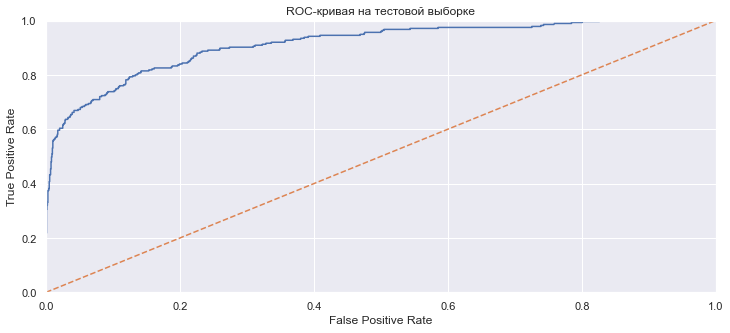

In [118]:
# построим график

# из метрики указали что есть что
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
# ROC-кривая случайной модели (выглядит как прямая) - диагональ
plt.plot([0, 1], [0, 1], linestyle='--')


#   установить границы осей от 0 до 1 >
plt.xlim(0, 1)
plt.ylim(0, 1)


#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# добавили к графику заголовок "ROC-кривая" функцией 
plt.title('ROC-кривая на тестовой выборке')
plt.show()

In [119]:
# посмотрим на Accuracy лучшей модели

result = model_2.score(features_test_dumm, target_test)
print("Accuracy лучшей модели на тестовой выборке:", round((result),2))

Accuracy лучшей модели на тестовой выборке: 0.87


# Отчет

Была обучена модель прогнозирующая отток клиентов с заданной точностью.

Ключевые шаги:
- Данные были собраны из разных таблиц в один датафрейм, заполнены пропуски, сгенерированы новые признаки, были удаленые ненужные признаки и найдены аномалии (было принято решение не удалять аномалии обнаруженные по межквартильному размаху в переменной `TotalCharges` в силу малого количества данных, а также отсутствия других признаков аномальности пользователей с такими значениями `TotalCharges`).
- Была исследована взаимосвязь и важность признаков, построены графики их отображающие (было принято решение не удалять скоррелированные признаки, т.к. мультиколлинеарность не вредит выбранным моделям). Качественные признаки были перекодированы, количественные - масштабированы.
- Были обучены несколько моделей, подобраны гиперпараметры, выбрана лучшая с наиболее высокой метрикой ROC-AUC. Лучшая модель была проверена на тестовой выборке (0,25% от обучающей, random_state=80523).  

Лучшая модель - **CatBoostClassifier**: <br>
лучшие гиперпараметры: {'learning_rate': 0.3, 'iterations': 500, 'depth': 3} <br>
ROC_AUC: 0.91 <br>
Accuracy: 0.87 <br>
время обучения: 1.47 сек. <br>
время предсказания: 0.01 сек. <br> 

Модель переобучена:  accuracy на обучающей выборке (0.91) выше, чем на тестовой выборке (0.87).

Модель обучалась на следующих признаках:

- MonthlyCharges
- TotalCharges
- how_long
- SeniorCitizen
- Type_One year
- Type_Two year
- PaperlessBilling_Yes
- PaymentMethod_Credit card (automatic)
- PaymentMethod_Electronic check
- PaymentMethod_Mailed check
- gender_Male
- Partner_Yes
- Dependents_Yes
- InternetService_Fiber optic
- InternetService_unknown
- OnlineSecurity_Yes
- OnlineBackup_Yes
- DeviceProtection_Yes
- TechSupport_Yes
- StreamingTV_Yes
- StreamingMovies_Yes
- MultipleLines_Yes

Самые важные признаки, влияющие на отток клиентов, согласно модели:
- как долго клиент с оператором `how_long`;
- сколько он всего заплатил за этот период `TotalCharges`;
- сколько он платит в месяц `MonthlyCharges`; 
- какой у него тип оплаты `Type` (с ежемесячным платежем или годовым);
- пользуется ли основной услугой параллельных линий `MultipleLines`;
- какими дополнительными услугами пользуется.

Затруднения:
- Поскольку данные за ок. 6 лет, если измерять количество времени, которое пользователь с оператором в месяцах, а не днях, значение целевой метрики ROC-AUC трудно достижимо.
- Дополнительные признаки могли бы повысить точность прогноза. Например, возраст ползователей. Данные о жизненном цикле пользователя: (когда подключил доп услугу, когда отлключил, сколько использовал одновременно) Стоимость основных и доп услуг.  
- Мультиколлинеарность самых важных признаков. Если сделать снижение размерности, то интерпретируемость результатов ухудшится. Если удалять - ухудшится качество прогноза.
- Как именно считать считать бизнес-метрику - подбор порога классификации.

На размер месячного платежа в свою очередь влияют:
- пользуется ли основными услугами и какой тип интернет;
- сколько дополнительных услуг (и каких) использует;
- какой тип оплаты.

Косвенно возможно вычислить стоимость дополнительных услуг в месяц.

**Портрет пользователя склонного уходить:**
- Не-пенсионер с партнером без детей;
- Технологически продвинут:
    - пробовал флагманские услуги (MultipleLines и оптоволоконный интернет, редко не пользуется интернетом вообще);
    - пробовал ок. 3-х доп. интернет-услуг (вероятно из числа OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies);
    - OnlineSecurity и TechSupport не пользуется;
    - на годовой или двухгодовой оплате из экономии чуть чаще, чем на месячной;
    - тем не менее в месяц за пробование дополнительных услуг платит сранвительно много - в среднем 75 у.е. (но есть две группы - те кто платят больше, ок 100 и используют больше доп услуг и быстрее уходят и те, кто платят меньше, ок 30 и уходят медленне);
    - предпочитает безналичный способ оплаты (электронным чеком или автоплатежем с банковской карты или счета);
    - чем больше доп. услуг успел попробовать, тем быстрее уходит;
- в среднем с оператором ок. 1000 дней.

Пользователям, которых модель сочла отточными, следует давать промокоды и специальные условия. При условии, что промокод удержит такого клиента, можно минимизировать потери оператора из-за оттока клиентов.  

**Метрика для бизнеса:**<br><br>
Высокая точность модели (высокие показатели ROC-AUC, accuracy) еще не означают, что внедрение модели позволит наилучшим образом минимизировать издержки бизнеса от ухода клиентов. (Хотя по сравнению с dummy моделью, которая предсказывает, что клиент не уйдет, конечно, позволит).<br><br>

Ошбика 1 рода: Если модель определила клиента как отточного, а он на самом деле лояльный (ложноположительный класс), то оператор потеряет 30% месячной платы (стоимость пропокода с целью удержать клиента).<br>
Ошибка 2 рода: Если модель определила клиента как лояльного, а он на самом деле отточный (ложноотрицательный класс), то оператор потеряет 100% месячной платы (уход клиента).<br><br>

Необходимо минимизировать ложноотрицательный класс (ошибку второго рода) путем сдвига пороговой вероятности к более высокой. 
Увеличивая пороговую вероятность, увеличиваем точность, но снижаем полноту модели.



In [120]:
# посмотрим на матрицу ошибок лучшей модели
from sklearn.metrics import confusion_matrix

predicted_test = pd.Series(model_2.predict(features_test_dumm))

print(confusion_matrix(target_test, predicted_test))


[[1334  152]
 [  71  204]]


Предположим, что в среднем в месяц пользователь платит 65 у.е. Тогда убыток от акции с промокодами для клиентов, которых модель определила в качестве отточных:
152 * (0.3 * 65) + 71 * 65

In [121]:
best_model_loss = (152 * (0.3 * 65)) + 71 * (65)
print(best_model_loss)

7579.0


Без акции или с dummy моделью, предсказывающей, что все клиенты лояльны (наибольшой класс), убытки:

In [122]:
target_test.value_counts()

0    1486
1     275
Name: churn, dtype: int64

In [123]:
dummy_model_loss =  275 * 65
print(dummy_model_loss)

17875


In [124]:
dummy_model_loss - best_model_loss

10296.0

Если всем раздать промокоды

In [125]:
promo_all_loss = 1761 * (0.3 * 65)
print(promo_all_loss)

34339.5


In [126]:
promo_all_loss - best_model_loss

26760.5

In [127]:
from sklearn.metrics import precision_score # точность
from sklearn.metrics import recall_score # полнота


probabilities_test = model_2.predict_proba(features_test_dumm)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0.5, 0.9, 0.02): # перебирает значения порогов 
    predicted_test = probabilities_one_test > threshold # сравниваем вероятность 1 с порогами
    precision = precision_score(target_test, predicted_test) # точность 
    recall = recall_score(target_test, predicted_test) # полнота
    B = 1 - precision
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f} | Ош 2 рода = {:.4f}".format(
        threshold, precision, recall, B))

Порог = 0.50 | Точность = 0.573, Полнота = 0.742 | Ош 2 рода = 0.4270
Порог = 0.52 | Точность = 0.594, Полнота = 0.738 | Ош 2 рода = 0.4064
Порог = 0.54 | Точность = 0.617, Полнота = 0.720 | Ош 2 рода = 0.3832
Порог = 0.56 | Точность = 0.635, Полнота = 0.709 | Ош 2 рода = 0.3648
Порог = 0.58 | Точность = 0.659, Полнота = 0.702 | Ош 2 рода = 0.3413
Порог = 0.60 | Точность = 0.683, Полнота = 0.691 | Ош 2 рода = 0.3165
Порог = 0.62 | Точность = 0.706, Полнота = 0.680 | Ош 2 рода = 0.2943
Порог = 0.64 | Точность = 0.736, Полнота = 0.669 | Ош 2 рода = 0.2640
Порог = 0.66 | Точность = 0.755, Полнота = 0.662 | Ош 2 рода = 0.2448
Порог = 0.68 | Точность = 0.771, Полнота = 0.647 | Ош 2 рода = 0.2294
Порог = 0.70 | Точность = 0.803, Полнота = 0.622 | Ош 2 рода = 0.1972
Порог = 0.72 | Точность = 0.820, Полнота = 0.615 | Ош 2 рода = 0.1796
Порог = 0.74 | Точность = 0.846, Полнота = 0.600 | Ош 2 рода = 0.1538
Порог = 0.76 | Точность = 0.860, Полнота = 0.582 | Ош 2 рода = 0.1398
Порог = 0.78 | Точно

In [139]:
# изменим порог лучшей модели
model_2.set_probability_threshold(0.6)

In [140]:
# посмотрим на матрицу ошибок модели с измененным порогом
predicted_test_threshold = pd.Series(model_2.predict(features_test_dumm))

print(confusion_matrix(target_test, predicted_test_threshold))

[[1398   88]
 [  85  190]]


In [189]:
# сравним убытки
best_model_threshold_loss = (88 * (0.3 * 65)) + 85 * (65)
print(f"убытки от лучшей модели без изменения порога классификации: {best_model_loss} у.е.")
print(f"убытки от лучшей модели с изменением порога классификации:{best_model_threshold_loss} у.е.")

убытки от лучшей модели без изменения порога классификации: 7579.0 у.е.
убытки от лучшей модели с изменением порога классификации:7241.0 у.е.


**Таким образом, изменяя порог классификации лучшей модели, можно добиться большей минимизации издержек бизнеса.** 

Посчитаем убытки без округления, т.е. для каждого пользователя в тестовой выборке.

In [142]:
# потери от промо-акции
PROMO = 0.3

In [176]:
# изменение порога классификации лучшей модели
model_2.set_probability_threshold(0.64)

In [177]:
# столбец с предсказаниями лучшей модели с измененным порогом
features_test['pred'] = model_2.predict(features_test_dumm)

In [178]:
# вернули таргет
features_test['target'] = target_test

In [179]:
final_test = features_test[['MonthlyCharges', 'pred', 'target']]

In [180]:
# посмотрим
display (final_test)

,MonthlyCharges,pred,target
customerID,,,
4694-PHWFW,19.95,0,0
8945-MUQUF,94.80,0,1
2267-WTPYD,94.00,1,1
9526-BIHHD,29.70,0,0
0781-LKXBR,100.50,0,0
...,...,...,...
9631-XEYKE,50.40,0,0
3551-HUAZH,74.40,0,0
8180-AKMJV,44.55,0,0


#### Убытки от промокодов выданных лояльным клиентам, которых модель ошибочно сочла отточными

In [185]:
FP = final_test.loc[
    (final_test['pred'] != final_test['target'])
    &
    (final_test['pred'] == 1)
]['MonthlyCharges'].sum()*PROMO

print(FP)

1650.5849999999996


#### Убытки из-за оттока клиентов, которых модель ошибочно сочла лояльными

In [186]:
FN = final_test.loc[
    (final_test['pred'] != final_test['target'])
    &
    (final_test['pred'] == 0)
]['MonthlyCharges'].sum()

print(FN)

6409.15


In [190]:
final_loss = FP + FN
print(f"убытки при от акции с промокодами при предсказании оттока лучшей моделью: {round(final_loss)} у.е.")
print(f"убытки при без акции и модели: {round(dummy_model_loss)} у.е.")
print(f"снижение убытков достигаемое за счет акции на основе предиктивной модели: {round(dummy_model_loss - final_loss)} у.е.")

убытки при от акции с промокодами при предсказании оттока лучшей моделью: 8060 у.е.
убытки при без акции и модели: 17875 у.е.
снижение убытков достигаемое за счет акции на основе предиктивной модели: 9815 у.е.
